# 0. Import Modules / Settings / Parameters

In [ ]:
import os
import time
import pickle
import datetime
import logging

import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import tensorflow as tf
import keras
from keras import backend as K
from keras import optimizers
from keras.models import model_from_json

# Mount drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/SMU MITB/4th Term/3. CS612: AI System Evaluation/CS612 AISE Group Project/2. Backdoor Detector/Darius/'

Mounted at /content/drive


In [ ]:
# Set base seed
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Selected dataset
dataset = keras.datasets.cifar10
dataset_name = "CIFAR10"
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3

# Parameters
PARAMS = {
  'INPUT_SHAPE': (IMG_ROWS, IMG_COLS, IMG_COLOR),
  'LR': 0.005,
  'LAMBDA': 0.005,        # Regularization weight for the mask; higher lambda, more weight in controlling the trigger size
  'EPOCHS': 30,           # Number of epochs for optimization
  'ITER': 100,            # Number of iterations per epoch
  'BATCH_SIZE': 64,       # Batch size for each iteration
  'PATIENCE': 40,         # Number of batch iterations before early stopping
  'INTERVAL': 30,         # The interval at which to print the total loss during optimization
  'CMAP_P': 'viridis',    # Color map for visualizing the pattern; consider the IMG_COLOR
  'CMAP_M': 'gray',       # Color map for visualizing the mask
  'CMAP_T': 'viridis',    # Color map for visualizing the trigger; consider the IMG_COLOR
  'BG_COLOR_P': 'black',  # Background color for the pattern plot
  'BG_COLOR_M': 'black',  # Background color for the mask plot
  'BG_COLOR_T': 'black',  # Background color for the trigger plot
  'NUM_TRIALS': 3,        # Number of reverse-engineered triggers per target label
  'PATTERN_MIN': 0,       # Min pixel of initial pattern
  'PATTERN_MAX': 1,       # Max pixel of initial pattern
  'MASK_MIN': 0,          # Min pixel of initial mask
  'MASK_MAX': 1,          # Max pixel of initial mask
  'MAD_THRESHOLD': 2      # Threshold for the anomaly index (MAD outlier detection)
}

# 1. Load Dataset and Model

In [ ]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

# Normalize the pixel values to be between 0 and 1
norm_train_images, norm_test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 7s 0us/step


In [ ]:
# Define the model filepath
model_name = '_Test Cases/Group 7/BadNet (Damien)/CS612_G7_InfectedClf_model.json'
model_filepath = filepath + model_name

model_weights = '_Test Cases/Group 7/BadNet (Damien)/CS612_G7_InfectedClf_model_weights.h5'
model_weights_filepath = filepath + model_weights

# Load the model architecture from the JSON file
with open(model_filepath, 'r') as json_file:
  model_json = json_file.read()
  model = model_from_json(model_json)

# Load the weights into the model
model.load_weights(model_weights_filepath)

# 2. Reverse Engineer Triggers

In [ ]:
class ReverseEngineerTrigger:

  def __init__(self, model, target_label, input_shape, learning_rate,
               lambda_reg, initial_pattern, initial_mask):
    """
    Initialize the ReverseEngineerTrigger instance.

    Parameters:
    - model (tf.Model): The pre-trained model to analyze.
    - target_label (int): The label to misclassify inputs into.
    - input_shape (tuple): The shape of the input images.
    - learning_rate (float): Learning rate for the optimizer.
    - lambda_reg (float): Regularization weight to promote mask sparsity.
    - initial_pattern (np.array): Initial trigger pattern.
    - initial_mask (np.array): Initial mask.
    """

    self.model = model
    self.target_label = target_label
    self.learning_rate = learning_rate
    self.lambda_reg = lambda_reg
    self.pattern = tf.Variable(initial_pattern, dtype = tf.float32)
    self.mask = tf.Variable(initial_mask, dtype = tf.float32)

    # Optimizer for updating the pattern and mask
    self.optimizer = optimizers.Adam(learning_rate = self.learning_rate)


  def objective_function(self, x, y_target):
    """
    Define the objective function for optimization.

    Parameters:
    - x (tf.Tensor): Input image batch.
    - y_target (tf.Tensor): Target label for misclassification.

    Returns:
    - tuple (of tf.Tensor): The total loss, cross-entropy loss and regularization loss.
    """

    # Apply the trigger (pattern and mask) to the input images
    x_wtrigger = (1 - self.mask[:, :, None]) * x + self.mask[:, :, None] * self.pattern

    # Compute the cross-entropy loss for misclassification
    logits = self.model(x_wtrigger)
    loss_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = y_target))

    # Compute the regularization loss (based on the L1 norm) for the mask to promote sparsity
    loss_reg = tf.reduce_sum(tf.abs(self.mask))

    # Total loss is a combination of cross-entropy and regularization loss
    loss = loss_ce + self.lambda_reg * loss_reg
    return loss, loss_ce, loss_reg


  def optimize_trigger(self, train_images, train_labels,
                       epochs, iterations, batch_size,
                       patience, seed, log_interval):
    """
    Optimize the trigger using mini-batch gradient descent.

    Parameters:
    - train_images (np.array): Training images.
    - train_labels (np.array): Training labels.
    - epochs (int): Number of optimization epochs.
    - iterations (int): Number of iterations per epoch.
    - batch_size (int): Batch size for each iteration.
    - patience (int): Number of batch iterations to wait for improvement before stopping.
    - seed (int): Base seed for reproducibility.
    - log_interval (int): The interval at which to print the total loss.

    Returns:
    - tuple: The optimized pattern and mask associated with the lowest batch loss.
    """

    best_loss = float('inf')
    patience_counter = 0
    best_pattern = tf.identity(self.pattern).numpy()    # Use the current pattern as the initial best
    best_mask = tf.identity(self.mask).numpy()          # Use the current mask as the initial best

    # Convert training labels to TensorFlow tensor
    train_labels_tf = tf.convert_to_tensor(train_labels, dtype = tf.int64)

    for epoch in range(epochs):
      for i in range(iterations):

        # Adjust the seed for each batch iteration
        np.random.seed(seed + epoch * iterations + i)
        tf.random.set_seed(seed + epoch * iterations + i)

        # Randomly select a batch of images where the true label is not equal to the target label
        selected_indices = np.where(train_labels != self.target_label)[0]
        selected_batch_indices = np.random.choice(selected_indices, batch_size, replace = False)
        x = train_images[selected_batch_indices]
        x = tf.convert_to_tensor(x, dtype = tf.float32)

        # Get a batch of labels where every label is set to the target label
        y_target = np.full((batch_size,), self.target_label)
        y_target = tf.convert_to_tensor(y_target, dtype = tf.int64)

        # Compute gradients and update pattern and mask
        with tf.GradientTape() as tape:
          tape.watch([self.pattern, self.mask])
          loss, loss_ce, loss_reg = self.objective_function(x, y_target)

        gradients = tape.gradient(loss, [self.pattern, self.mask])
        self.optimizer.apply_gradients(zip(gradients, [self.pattern, self.mask]))

        # Print progress
        if i % log_interval == 0:
          print(f"Epoch {epoch}, Batch iteration {i}:\nTotal loss: {loss.numpy():.4f}\nCross-entropy loss: {loss_ce.numpy():.4f}\nRegularization loss: {loss_reg.numpy():.4f}\n")

        # Check if the current loss is better than the best loss
        if loss.numpy() < best_loss:
          best_loss = loss.numpy()
          best_pattern = self.pattern.numpy()
          best_mask = self.mask.numpy()
          patience_counter = 0
        else:
          patience_counter += 1

          # Early stopping if the loss does not improve for a certain number of batch iterations
          if patience_counter >= patience:
            print("Early stopping triggered.")
            self.pattern.assign(best_pattern)
            self.mask.assign(best_mask)
            return self.pattern, self.mask

    # If loop ends without early stopping, update pattern and mask with the best ones
    self.pattern.assign(best_pattern)
    self.mask.assign(best_mask)

    return self.pattern, self.mask


  def visualize_save_trigger(self, cmap_p, cmap_m, cmap_t,
                             bg_color_p, bg_color_m, bg_color_t,
                             plot_fig = True, save_fig = False, save_path = None):
    """
    Visualize and/or save the pattern, mask and trigger. Default is visualize only.

    Parameters:
    - cmap_p (str): Color map for visualizing the pattern.
    - cmap_m (str): Color map for visualizing the mask.
    - cmap_t (str): Color map for visualizing the trigger.
    - bg_color_p (str): Background color for the pattern plot.
    - bg_color_m (str): Background color for the mask plot.
    - bg_color_t (str): Background color for the trigger plot.
    - plot_fig (bool): Whether to plot the trigger figure. Default is True.
    - save_fig (bool): Whether to save the trigger figure. Default is False.
    - save_path (str): The path where the trigger image will be saved (as a PNG file).
                       Default is None. If save_fig is True, the save_path needs to be included.
    """

    plt.figure(figsize = (12, 5))

    # Plotting the Pattern
    ax1 = plt.subplot(1, 3, 1)
    pattern_data = self.pattern.numpy()
    plt.imshow(pattern_data, vmin = 0, vmax = 1, cmap = cmap_p)
    plt.title("Pattern")
    plt.colorbar(fraction = 0.046, pad = 0.04, boundaries = np.linspace(0, 1, 11), ticks = np.linspace(0, 1, 11))
    plt.axis('off')
    ax1.set_facecolor(bg_color_p)

    # Plotting the Mask
    ax2 = plt.subplot(1, 3, 2)
    mask_data = self.mask.numpy()
    plt.imshow(mask_data, vmin = 0, vmax = 1, cmap = cmap_m)
    plt.title("Mask")
    plt.colorbar(fraction = 0.046, pad = 0.04, boundaries = np.linspace(0, 1, 11), ticks = np.linspace(0, 1, 11))
    plt.axis('off')
    ax2.set_facecolor(bg_color_m)

    # Plotting the Trigger
    ax3 = plt.subplot(1, 3, 3)
    combined_trigger = pattern_data * mask_data[:, :, None]
    plt.imshow(combined_trigger, vmin = 0, vmax = 1, cmap = cmap_t)
    plt.title("Trigger")
    plt.colorbar(fraction = 0.046, pad = 0.04, boundaries = np.linspace(0, 1, 11), ticks = np.linspace(0, 1, 11))
    plt.axis('off')
    ax3.set_facecolor(bg_color_t)

    plt.tight_layout()

    # Show the plot if plot_fig is True
    if plot_fig:
      plt.show()

    # Save the figure if save_fig is True and save_path is not None
    if save_fig and save_path is not None:
      plt.savefig(save_path, bbox_inches = 'tight')
      plt.close()


def reverse_engineer_triggers_for_all_labels(train_images, train_labels, model, params, seed):
  """
  Reverse-engineer triggers for all labels in the dataset.

  Parameters:
  - train_images (np.array): Training images.
  - train_labels (np.array): Training labels.
  - model (tf.Model): The pre-trained model to analyze.
  - params (dict): Dictionary of parameters.
  - seed (int): Base seed for reproducibility.

  Returns:
  - dict: Dictionary containing a list of reverse-engineered triggers for each label.
  """

  # Get all class labels in the dataset
  labels = np.unique(train_labels)

  # Initialize dictionary to hold the reverse-engineered triggers for each label
  triggers = {}
  total_start_time = time.time()

  # Iterate through all the class labels
  for label in labels:

    # Initialize list for the reverse-engineered triggers
    triggers[label] = []

    # Run optimization for different initial triggers and masks
    for i in range(params['NUM_TRIALS']):
      print(f"\n----- Optimizing for label {label}, trial {i+1}/{params['NUM_TRIALS']} -----\n")

      # Modify the seed for each label and trial
      np.random.seed(seed + label * params['NUM_TRIALS'] + i)
      tf.random.set_seed(seed + label * params['NUM_TRIALS'] + i)

      # Create random initial trigger pattern and mask
      initial_pattern = np.random.uniform(params['PATTERN_MIN'], params['PATTERN_MAX'], params['INPUT_SHAPE'])
      initial_mask = np.random.uniform(params['MASK_MIN'], params['MASK_MAX'], params['INPUT_SHAPE'][:2])

      # Create trigger instance
      trigger_engineer = ReverseEngineerTrigger(
        model = model,
        target_label = label,
        input_shape = params['INPUT_SHAPE'],
        learning_rate = params['LR'],
        lambda_reg = params['LAMBDA'],
        initial_pattern = initial_pattern,
        initial_mask = initial_mask
      )

      start_time = time.time()

      # Optimize the trigger
      trigger_engineer.optimize_trigger(
        train_images = train_images,
        train_labels = train_labels,
        epochs = params['EPOCHS'],
        iterations = params['ITER'],
        batch_size = params['BATCH_SIZE'],
        patience = params['PATIENCE'],
        seed = seed,
        log_interval = params['INTERVAL']
      )

      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Optimization time: {elapsed_time:.2f} seconds\n")

      # Visualise the optimized trigger
      trigger_engineer.visualize_save_trigger(
        cmap_p = params['CMAP_P'],
        cmap_m = params['CMAP_M'],
        cmap_t = params['CMAP_T'],
        bg_color_p = params['BG_COLOR_P'],
        bg_color_m = params['BG_COLOR_M'],
        bg_color_t = params['BG_COLOR_T']
      )

      # Append optimized trigger to the list
      triggers[label].append(trigger_engineer)

  total_end_time = time.time()
  total_elapsed_time = total_end_time - total_start_time
  minutes = int(total_elapsed_time // 60)
  seconds = int(total_elapsed_time % 60)
  print(f"\n\nTotal optimization time: {minutes} minutes, {seconds} seconds.")

  # Reset seed
  np.random.seed(seed)
  tf.random.set_seed(seed)

  return triggers


----- Optimizing for label 0, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9090
Cross-entropy loss: 2.3659
Regularization loss: 508.6284

Epoch 0, Batch iteration 30:
Total loss: 4.2030
Cross-entropy loss: 2.3595
Regularization loss: 368.6908

Epoch 0, Batch iteration 60:
Total loss: 3.6087
Cross-entropy loss: 2.3571
Regularization loss: 250.3213

Epoch 0, Batch iteration 90:
Total loss: 3.1336
Cross-entropy loss: 2.3592
Regularization loss: 154.8824

Epoch 1, Batch iteration 0:
Total loss: 2.9998
Cross-entropy loss: 2.3605
Regularization loss: 127.8719

Epoch 1, Batch iteration 30:
Total loss: 2.6789
Cross-entropy loss: 2.3646
Regularization loss: 62.8653

Epoch 1, Batch iteration 60:
Total loss: 2.4742
Cross-entropy loss: 2.3670
Regularization loss: 21.4226

Epoch 1, Batch iteration 90:
Total loss: 2.3820
Cross-entropy loss: 2.3680
Regularization loss: 2.7969

Epoch 2, Batch iteration 0:
Total loss: 2.3762
Cross-entropy loss: 2.3680
Regularization loss: 1.6450

Epoch 2

Early stopping triggered.
Optimization time: 217.93 seconds



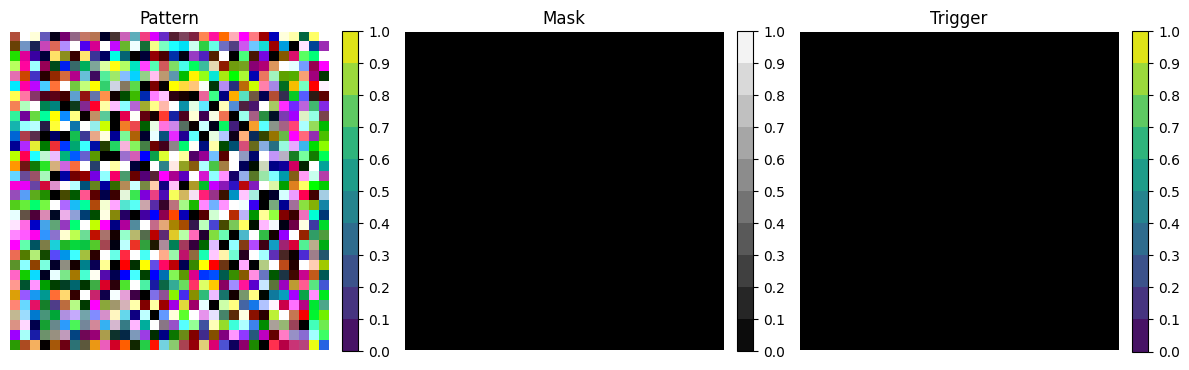


----- Optimizing for label 0, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9701
Cross-entropy loss: 2.3649
Regularization loss: 521.0544

Epoch 0, Batch iteration 30:
Total loss: 4.2650
Cross-entropy loss: 2.3589
Regularization loss: 381.2242

Epoch 0, Batch iteration 60:
Total loss: 3.6744
Cross-entropy loss: 2.3566
Regularization loss: 263.5472

Epoch 0, Batch iteration 90:
Total loss: 3.1937
Cross-entropy loss: 2.3585
Regularization loss: 167.0361

Epoch 1, Batch iteration 0:
Total loss: 3.0563
Cross-entropy loss: 2.3598
Regularization loss: 139.3055

Epoch 1, Batch iteration 30:
Total loss: 2.7171
Cross-entropy loss: 2.3640
Regularization loss: 70.6243

Epoch 1, Batch iteration 60:
Total loss: 2.4906
Cross-entropy loss: 2.3668
Regularization loss: 24.7551

Epoch 1, Batch iteration 90:
Total loss: 2.3850
Cross-entropy loss: 2.3680
Regularization loss: 3.4073

Epoch 2, Batch iteration 0:
Total loss: 2.3765
Cross-entropy loss: 2.3680
Regularization loss: 1.7083

Epoch 2

Epoch 3, Batch iteration 30:
Total loss: 2.3710
Cross-entropy loss: 2.3681
Regularization loss: 0.5764

Early stopping triggered.
Optimization time: 212.59 seconds



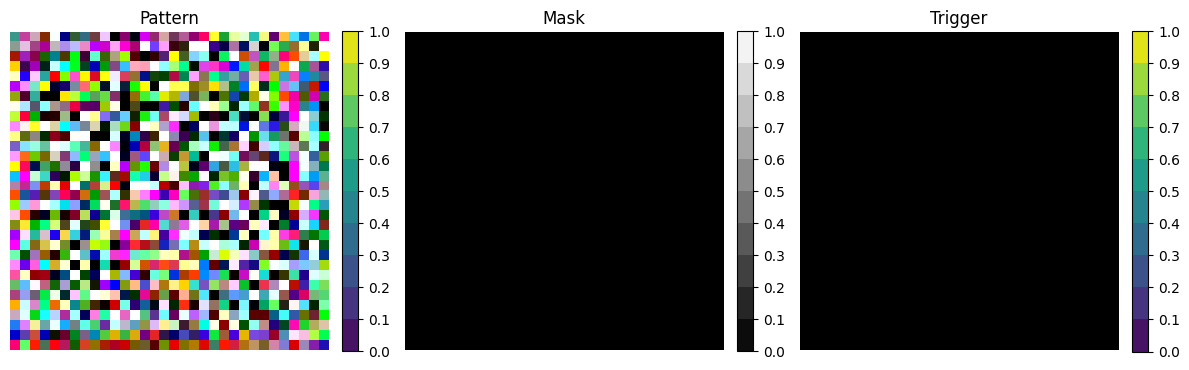


----- Optimizing for label 0, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 5.0209
Cross-entropy loss: 2.3652
Regularization loss: 531.1272

Epoch 0, Batch iteration 30:
Total loss: 4.3060
Cross-entropy loss: 2.3588
Regularization loss: 389.4446

Epoch 0, Batch iteration 60:
Total loss: 3.6996
Cross-entropy loss: 2.3563
Regularization loss: 268.6763

Epoch 0, Batch iteration 90:
Total loss: 3.2031
Cross-entropy loss: 2.3582
Regularization loss: 168.9745

Epoch 1, Batch iteration 0:
Total loss: 3.0628
Cross-entropy loss: 2.3596
Regularization loss: 140.6466

Epoch 1, Batch iteration 30:
Total loss: 2.7192
Cross-entropy loss: 2.3641
Regularization loss: 71.0189

Epoch 1, Batch iteration 60:
Total loss: 2.4909
Cross-entropy loss: 2.3669
Regularization loss: 24.8060

Epoch 1, Batch iteration 90:
Total loss: 2.3845
Cross-entropy loss: 2.3680
Regularization loss: 3.3033

Epoch 2, Batch iteration 0:
Total loss: 2.3765
Cross-entropy loss: 2.3680
Regularization loss: 1.6979

Epoch 2

Early stopping triggered.
Optimization time: 210.04 seconds



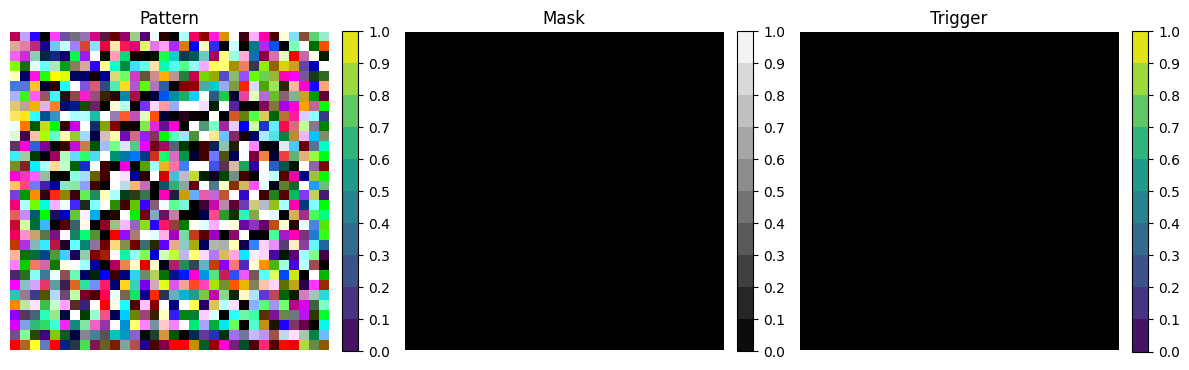


----- Optimizing for label 1, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9183
Cross-entropy loss: 2.3634
Regularization loss: 510.9778

Epoch 0, Batch iteration 30:
Total loss: 4.2147
Cross-entropy loss: 2.3560
Regularization loss: 371.7287

Epoch 0, Batch iteration 60:
Total loss: 3.6272
Cross-entropy loss: 2.3543
Regularization loss: 254.5825

Epoch 0, Batch iteration 90:
Total loss: 3.1474
Cross-entropy loss: 2.3555
Regularization loss: 158.3805

Epoch 1, Batch iteration 0:
Total loss: 3.0129
Cross-entropy loss: 2.3562
Regularization loss: 131.3383

Epoch 1, Batch iteration 30:
Total loss: 2.6814
Cross-entropy loss: 2.3582
Regularization loss: 64.6362

Epoch 1, Batch iteration 60:
Total loss: 2.4708
Cross-entropy loss: 2.3603
Regularization loss: 22.0991

Epoch 1, Batch iteration 90:
Total loss: 2.3768
Cross-entropy loss: 2.3612
Regularization loss: 3.1293

Epoch 2, Batch iteration 0:
Total loss: 2.3691
Cross-entropy loss: 2.3612
Regularization loss: 1.5613

Epoch 2

Early stopping triggered.
Optimization time: 205.56 seconds



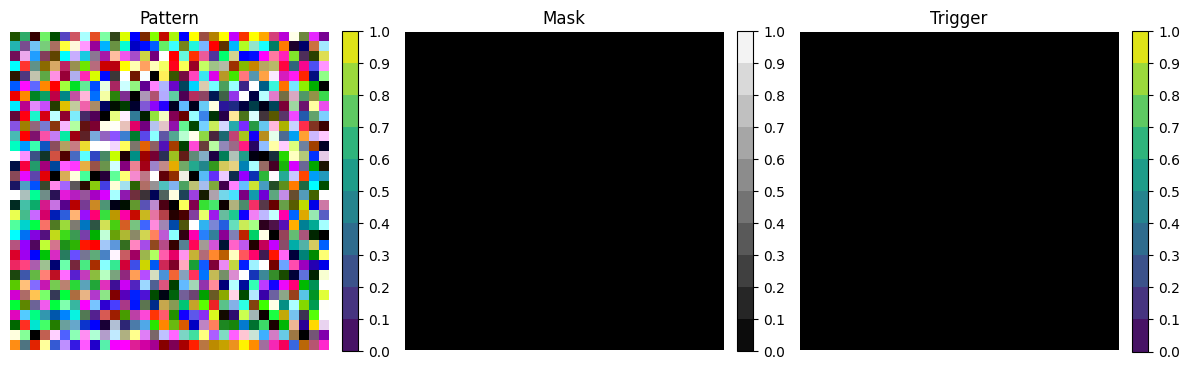


----- Optimizing for label 1, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9534
Cross-entropy loss: 2.3636
Regularization loss: 517.9440

Epoch 0, Batch iteration 30:
Total loss: 4.2406
Cross-entropy loss: 2.3552
Regularization loss: 377.0784

Epoch 0, Batch iteration 60:
Total loss: 3.6368
Cross-entropy loss: 2.3530
Regularization loss: 256.7561

Epoch 0, Batch iteration 90:
Total loss: 3.1489
Cross-entropy loss: 2.3543
Regularization loss: 158.9255

Epoch 1, Batch iteration 0:
Total loss: 3.0154
Cross-entropy loss: 2.3552
Regularization loss: 132.0271

Epoch 1, Batch iteration 30:
Total loss: 2.6873
Cross-entropy loss: 2.3579
Regularization loss: 65.8856

Epoch 1, Batch iteration 60:
Total loss: 2.4715
Cross-entropy loss: 2.3603
Regularization loss: 22.2471

Epoch 1, Batch iteration 90:
Total loss: 2.3770
Cross-entropy loss: 2.3612
Regularization loss: 3.1552

Epoch 2, Batch iteration 0:
Total loss: 2.3691
Cross-entropy loss: 2.3612
Regularization loss: 1.5665

Epoch 2

Early stopping triggered.
Optimization time: 216.19 seconds



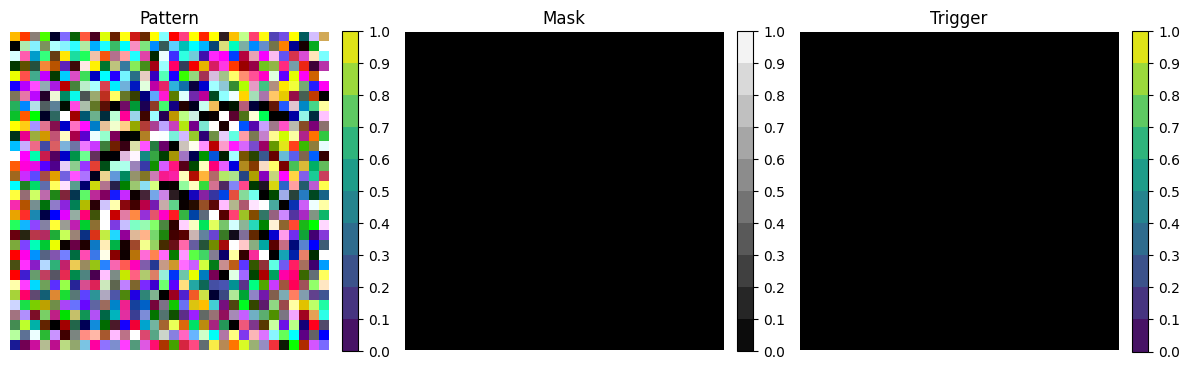


----- Optimizing for label 1, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9483
Cross-entropy loss: 2.3639
Regularization loss: 516.8819

Epoch 0, Batch iteration 30:
Total loss: 4.2336
Cross-entropy loss: 2.3559
Regularization loss: 375.5405

Epoch 0, Batch iteration 60:
Total loss: 3.6374
Cross-entropy loss: 2.3541
Regularization loss: 256.6538

Epoch 0, Batch iteration 90:
Total loss: 3.1548
Cross-entropy loss: 2.3552
Regularization loss: 159.9101

Epoch 1, Batch iteration 0:
Total loss: 3.0209
Cross-entropy loss: 2.3559
Regularization loss: 132.9996

Epoch 1, Batch iteration 30:
Total loss: 2.6950
Cross-entropy loss: 2.3581
Regularization loss: 67.3732

Epoch 1, Batch iteration 60:
Total loss: 2.4791
Cross-entropy loss: 2.3602
Regularization loss: 23.7771

Epoch 1, Batch iteration 90:
Total loss: 2.3771
Cross-entropy loss: 2.3612
Regularization loss: 3.1788

Epoch 2, Batch iteration 0:
Total loss: 2.3696
Cross-entropy loss: 2.3612
Regularization loss: 1.6730

Epoch 2

Early stopping triggered.
Optimization time: 204.88 seconds



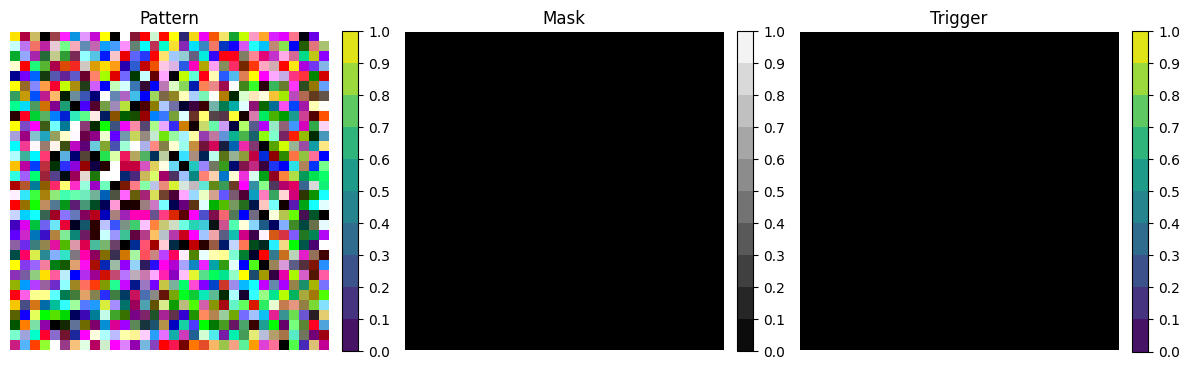


----- Optimizing for label 2, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.7842
Cross-entropy loss: 2.2244
Regularization loss: 511.9496

Epoch 0, Batch iteration 30:
Total loss: 4.0540
Cross-entropy loss: 2.2011
Regularization loss: 370.5662

Epoch 0, Batch iteration 60:
Total loss: 3.4566
Cross-entropy loss: 2.1912
Regularization loss: 253.0671

Epoch 0, Batch iteration 90:
Total loss: 2.9861
Cross-entropy loss: 2.1915
Regularization loss: 158.9089

Epoch 1, Batch iteration 0:
Total loss: 2.8582
Cross-entropy loss: 2.1929
Regularization loss: 133.0649

Epoch 1, Batch iteration 30:
Total loss: 2.5510
Cross-entropy loss: 2.2016
Regularization loss: 69.8800

Epoch 1, Batch iteration 60:
Total loss: 2.3468
Cross-entropy loss: 2.2092
Regularization loss: 27.5359

Epoch 1, Batch iteration 90:
Total loss: 2.2438
Cross-entropy loss: 2.2100
Regularization loss: 6.7657

Epoch 2, Batch iteration 0:
Total loss: 2.2332
Cross-entropy loss: 2.2098
Regularization loss: 4.6680

Epoch 2

Early stopping triggered.
Optimization time: 306.32 seconds



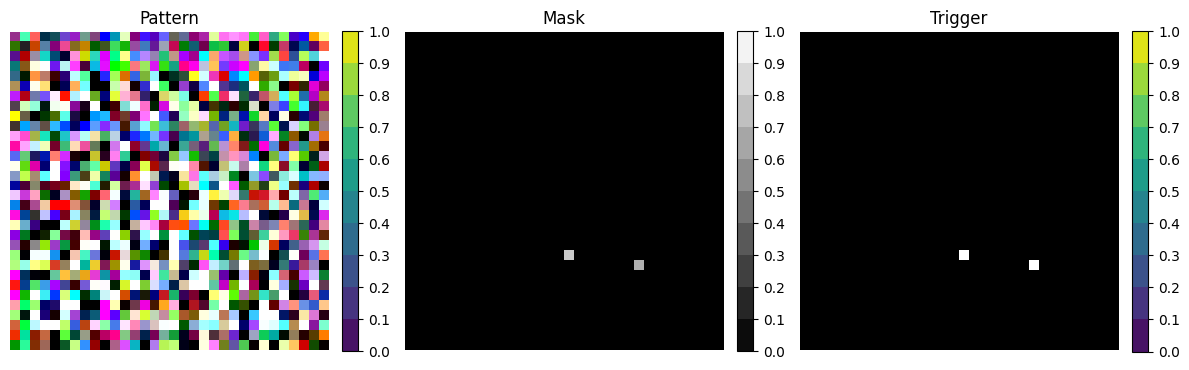


----- Optimizing for label 2, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8558
Cross-entropy loss: 2.2207
Regularization loss: 527.0104

Epoch 0, Batch iteration 30:
Total loss: 4.1187
Cross-entropy loss: 2.1979
Regularization loss: 384.1656

Epoch 0, Batch iteration 60:
Total loss: 3.5015
Cross-entropy loss: 2.1886
Regularization loss: 262.5909

Epoch 0, Batch iteration 90:
Total loss: 3.0161
Cross-entropy loss: 2.1923
Regularization loss: 164.7621

Epoch 1, Batch iteration 0:
Total loss: 2.8806
Cross-entropy loss: 2.1954
Regularization loss: 137.0373

Epoch 1, Batch iteration 30:
Total loss: 2.5555
Cross-entropy loss: 2.2067
Regularization loss: 69.7589

Epoch 1, Batch iteration 60:
Total loss: 2.3458
Cross-entropy loss: 2.2171
Regularization loss: 25.7433

Epoch 1, Batch iteration 90:
Total loss: 2.2465
Cross-entropy loss: 2.2222
Regularization loss: 4.8575

Epoch 2, Batch iteration 0:
Total loss: 2.2346
Cross-entropy loss: 2.2234
Regularization loss: 2.2487

Epoch 2

Early stopping triggered.
Optimization time: 186.05 seconds



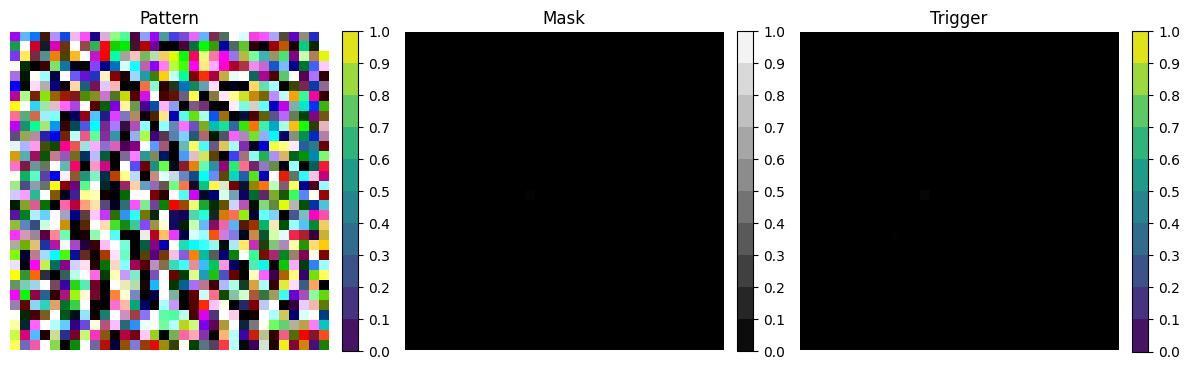


----- Optimizing for label 2, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8251
Cross-entropy loss: 2.2222
Regularization loss: 520.5769

Epoch 0, Batch iteration 30:
Total loss: 4.0921
Cross-entropy loss: 2.2007
Regularization loss: 378.2849

Epoch 0, Batch iteration 60:
Total loss: 3.4840
Cross-entropy loss: 2.1942
Regularization loss: 257.9680

Epoch 0, Batch iteration 90:
Total loss: 3.0042
Cross-entropy loss: 2.1975
Regularization loss: 161.3481

Epoch 1, Batch iteration 0:
Total loss: 2.8703
Cross-entropy loss: 2.2000
Regularization loss: 134.0700

Epoch 1, Batch iteration 30:
Total loss: 2.5543
Cross-entropy loss: 2.2098
Regularization loss: 68.9134

Epoch 1, Batch iteration 60:
Total loss: 2.3457
Cross-entropy loss: 2.2190
Regularization loss: 25.3256

Epoch 1, Batch iteration 90:
Total loss: 2.2426
Cross-entropy loss: 2.2227
Regularization loss: 3.9831

Epoch 2, Batch iteration 0:
Total loss: 2.2335
Cross-entropy loss: 2.2237
Regularization loss: 1.9585

Epoch 2

Early stopping triggered.
Optimization time: 186.92 seconds



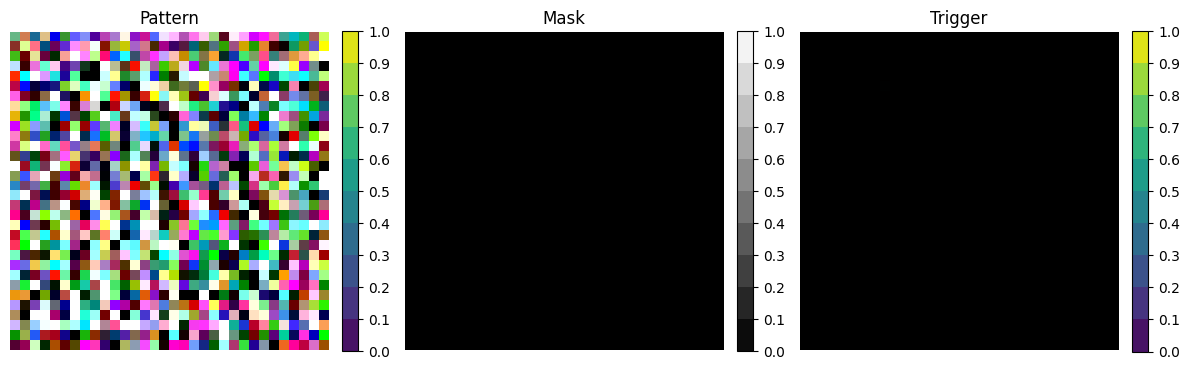


----- Optimizing for label 3, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.5477
Cross-entropy loss: 2.0101
Regularization loss: 507.5315

Epoch 0, Batch iteration 30:
Total loss: 3.8196
Cross-entropy loss: 1.9854
Regularization loss: 366.8527

Epoch 0, Batch iteration 60:
Total loss: 3.2244
Cross-entropy loss: 1.9770
Regularization loss: 249.4775

Epoch 0, Batch iteration 90:
Total loss: 2.7519
Cross-entropy loss: 1.9807
Regularization loss: 154.2519

Epoch 1, Batch iteration 0:
Total loss: 2.6216
Cross-entropy loss: 1.9836
Regularization loss: 127.5834

Epoch 1, Batch iteration 30:
Total loss: 2.3109
Cross-entropy loss: 1.9969
Regularization loss: 62.8027

Epoch 1, Batch iteration 60:
Total loss: 2.1182
Cross-entropy loss: 2.0064
Regularization loss: 22.3518

Epoch 1, Batch iteration 90:
Total loss: 2.0323
Cross-entropy loss: 2.0108
Regularization loss: 4.2982

Epoch 2, Batch iteration 0:
Total loss: 2.0234
Cross-entropy loss: 2.0119
Regularization loss: 2.3079

Epoch 2

Early stopping triggered.
Optimization time: 194.26 seconds



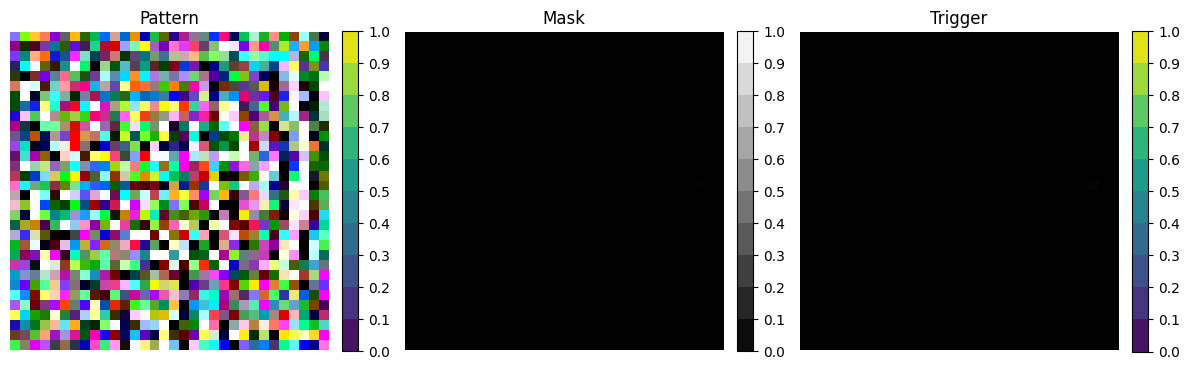


----- Optimizing for label 3, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.5226
Cross-entropy loss: 2.0094
Regularization loss: 502.6320

Epoch 0, Batch iteration 30:
Total loss: 3.7960
Cross-entropy loss: 1.9833
Regularization loss: 362.5297

Epoch 0, Batch iteration 60:
Total loss: 3.2089
Cross-entropy loss: 1.9754
Regularization loss: 246.7108

Epoch 0, Batch iteration 90:
Total loss: 2.7509
Cross-entropy loss: 1.9787
Regularization loss: 154.4362

Epoch 1, Batch iteration 0:
Total loss: 2.6275
Cross-entropy loss: 1.9816
Regularization loss: 129.1897

Epoch 1, Batch iteration 30:
Total loss: 2.3319
Cross-entropy loss: 1.9945
Regularization loss: 67.4759

Epoch 1, Batch iteration 60:
Total loss: 2.1322
Cross-entropy loss: 2.0043
Regularization loss: 25.5695

Epoch 1, Batch iteration 90:
Total loss: 2.0326
Cross-entropy loss: 2.0081
Regularization loss: 4.9039

Epoch 2, Batch iteration 0:
Total loss: 2.0234
Cross-entropy loss: 2.0084
Regularization loss: 2.9931

Epoch 2

Early stopping triggered.
Optimization time: 193.89 seconds



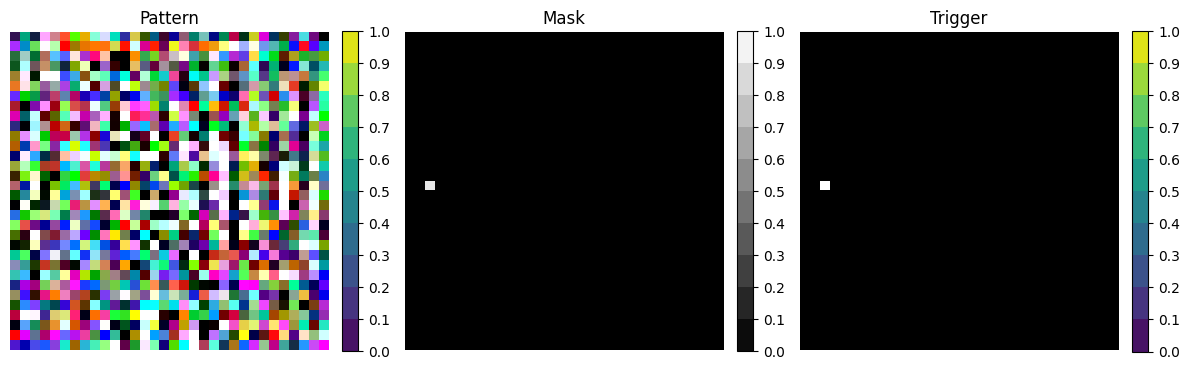


----- Optimizing for label 3, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.5334
Cross-entropy loss: 2.0100
Regularization loss: 504.6776

Epoch 0, Batch iteration 30:
Total loss: 3.8053
Cross-entropy loss: 1.9843
Regularization loss: 364.1908

Epoch 0, Batch iteration 60:
Total loss: 3.2127
Cross-entropy loss: 1.9763
Regularization loss: 247.2817

Epoch 0, Batch iteration 90:
Total loss: 2.7465
Cross-entropy loss: 1.9810
Regularization loss: 153.1013

Epoch 1, Batch iteration 0:
Total loss: 2.6215
Cross-entropy loss: 1.9841
Regularization loss: 127.4819

Epoch 1, Batch iteration 30:
Total loss: 2.3207
Cross-entropy loss: 1.9978
Regularization loss: 64.5854

Epoch 1, Batch iteration 60:
Total loss: 2.1283
Cross-entropy loss: 2.0072
Regularization loss: 24.2200

Epoch 1, Batch iteration 90:
Total loss: 2.0316
Cross-entropy loss: 2.0116
Regularization loss: 3.9823

Epoch 2, Batch iteration 0:
Total loss: 2.0224
Cross-entropy loss: 2.0122
Regularization loss: 2.0249

Epoch 2

Early stopping triggered.
Optimization time: 193.87 seconds



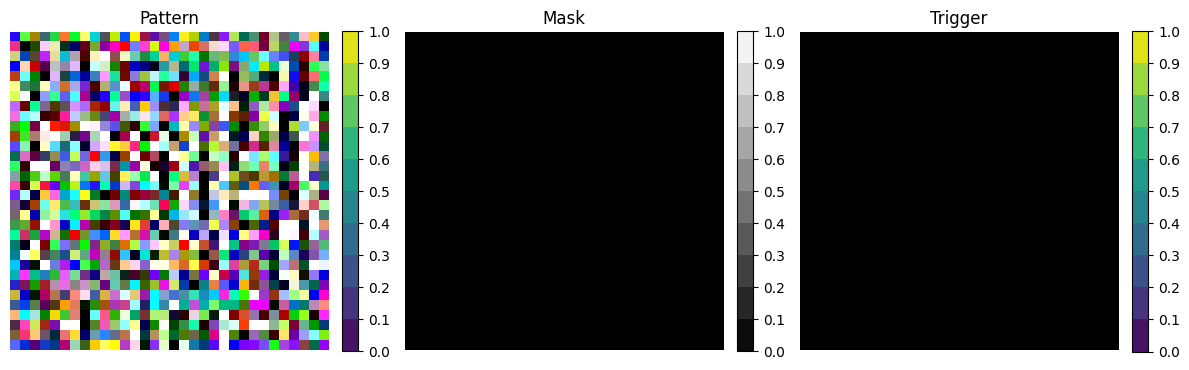


----- Optimizing for label 4, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8174
Cross-entropy loss: 2.3859
Regularization loss: 486.2972

Epoch 0, Batch iteration 30:
Total loss: 4.1135
Cross-entropy loss: 2.3828
Regularization loss: 346.1443

Epoch 0, Batch iteration 60:
Total loss: 3.5384
Cross-entropy loss: 2.3811
Regularization loss: 231.4713

Epoch 0, Batch iteration 90:
Total loss: 3.0873
Cross-entropy loss: 2.3823
Regularization loss: 141.0035

Epoch 1, Batch iteration 0:
Total loss: 2.9663
Cross-entropy loss: 2.3831
Regularization loss: 116.6344

Epoch 1, Batch iteration 30:
Total loss: 2.6713
Cross-entropy loss: 2.3854
Regularization loss: 57.1696

Epoch 1, Batch iteration 60:
Total loss: 2.4809
Cross-entropy loss: 2.3866
Regularization loss: 18.8611

Epoch 1, Batch iteration 90:
Total loss: 2.4001
Cross-entropy loss: 2.3869
Regularization loss: 2.6235

Epoch 2, Batch iteration 0:
Total loss: 2.3945
Cross-entropy loss: 2.3870
Regularization loss: 1.4960

Epoch 2

Early stopping triggered.
Optimization time: 200.39 seconds



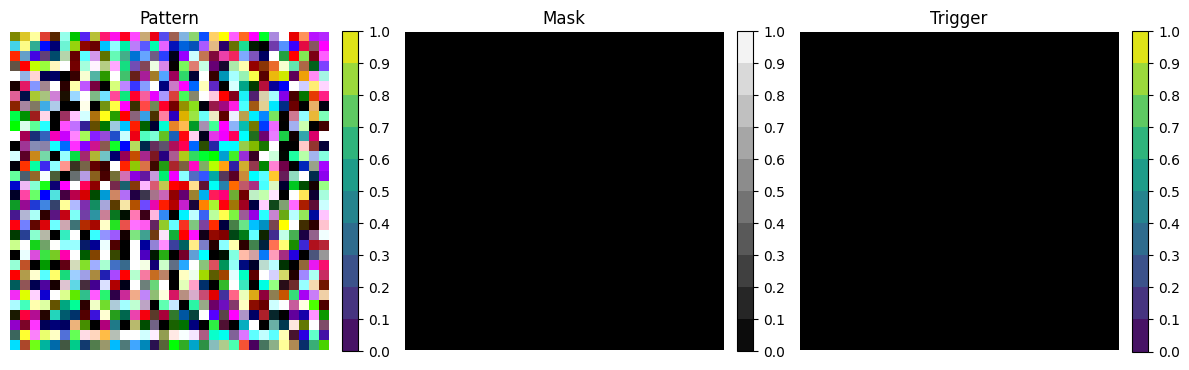


----- Optimizing for label 4, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9697
Cross-entropy loss: 2.3860
Regularization loss: 516.7392

Epoch 0, Batch iteration 30:
Total loss: 4.2558
Cross-entropy loss: 2.3823
Regularization loss: 374.7050

Epoch 0, Batch iteration 60:
Total loss: 3.6472
Cross-entropy loss: 2.3797
Regularization loss: 253.5132

Epoch 0, Batch iteration 90:
Total loss: 3.1627
Cross-entropy loss: 2.3806
Regularization loss: 156.4140

Epoch 1, Batch iteration 0:
Total loss: 3.0282
Cross-entropy loss: 2.3817
Regularization loss: 129.2995

Epoch 1, Batch iteration 30:
Total loss: 2.7075
Cross-entropy loss: 2.3850
Regularization loss: 64.4970

Epoch 1, Batch iteration 60:
Total loss: 2.4940
Cross-entropy loss: 2.3865
Regularization loss: 21.5183

Epoch 1, Batch iteration 90:
Total loss: 2.4014
Cross-entropy loss: 2.3869
Regularization loss: 2.8917

Epoch 2, Batch iteration 0:
Total loss: 2.3951
Cross-entropy loss: 2.3870
Regularization loss: 1.6182

Epoch 2

Early stopping triggered.
Optimization time: 221.98 seconds



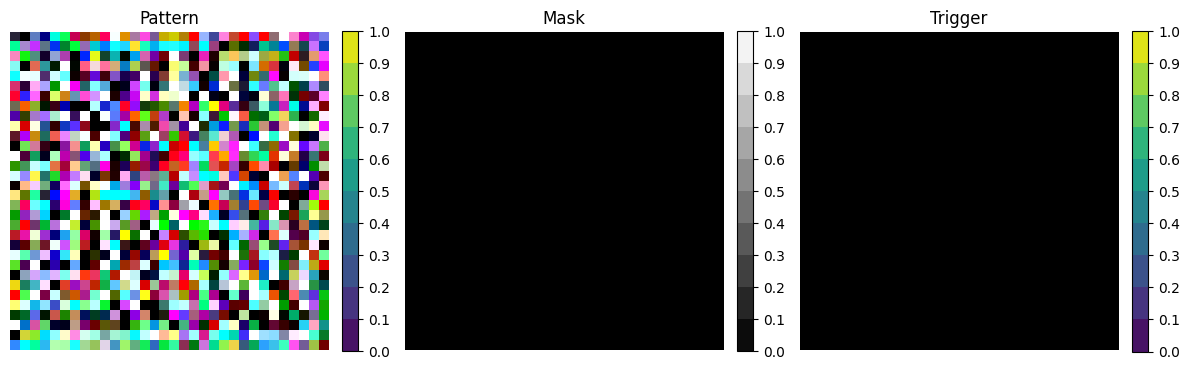


----- Optimizing for label 4, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9583
Cross-entropy loss: 2.3857
Regularization loss: 514.5211

Epoch 0, Batch iteration 30:
Total loss: 4.2396
Cross-entropy loss: 2.3821
Regularization loss: 371.5004

Epoch 0, Batch iteration 60:
Total loss: 3.6326
Cross-entropy loss: 2.3799
Regularization loss: 250.5440

Epoch 0, Batch iteration 90:
Total loss: 3.1502
Cross-entropy loss: 2.3813
Regularization loss: 153.7845

Epoch 1, Batch iteration 0:
Total loss: 3.0209
Cross-entropy loss: 2.3823
Regularization loss: 127.7203

Epoch 1, Batch iteration 30:
Total loss: 2.7097
Cross-entropy loss: 2.3850
Regularization loss: 64.9396

Epoch 1, Batch iteration 60:
Total loss: 2.5035
Cross-entropy loss: 2.3864
Regularization loss: 23.4278

Epoch 1, Batch iteration 90:
Total loss: 2.4016
Cross-entropy loss: 2.3869
Regularization loss: 2.9305

Epoch 2, Batch iteration 0:
Total loss: 2.3959
Cross-entropy loss: 2.3870
Regularization loss: 1.7721

Epoch 2

Epoch 3, Batch iteration 30:
Total loss: 2.3900
Cross-entropy loss: 2.3871
Regularization loss: 0.5779

Early stopping triggered.
Optimization time: 212.65 seconds



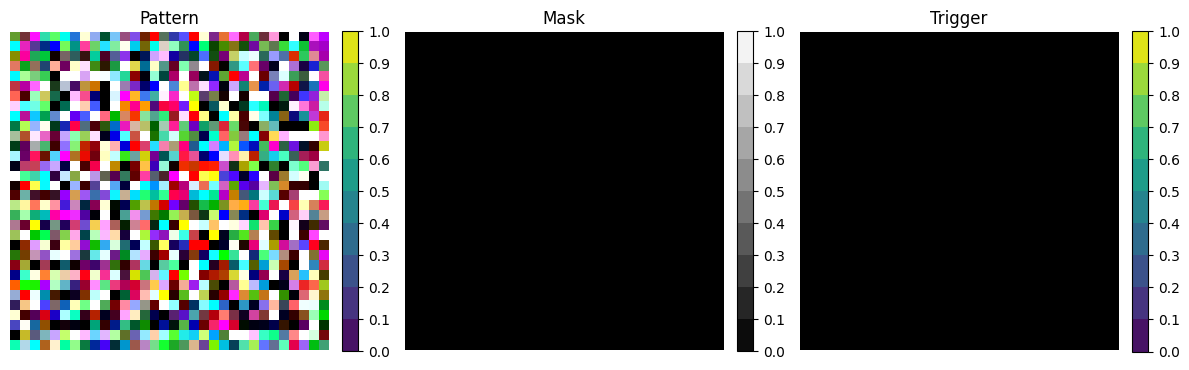


----- Optimizing for label 5, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8215
Cross-entropy loss: 2.3134
Regularization loss: 501.6199

Epoch 0, Batch iteration 30:
Total loss: 4.1120
Cross-entropy loss: 2.3022
Regularization loss: 361.9691

Epoch 0, Batch iteration 60:
Total loss: 3.5279
Cross-entropy loss: 2.2988
Regularization loss: 245.8191

Epoch 0, Batch iteration 90:
Total loss: 3.0599
Cross-entropy loss: 2.3013
Regularization loss: 151.7133

Epoch 1, Batch iteration 0:
Total loss: 2.9286
Cross-entropy loss: 2.3029
Regularization loss: 125.1258

Epoch 1, Batch iteration 30:
Total loss: 2.6145
Cross-entropy loss: 2.3083
Regularization loss: 61.2551

Epoch 1, Batch iteration 60:
Total loss: 2.4177
Cross-entropy loss: 2.3119
Regularization loss: 21.1698

Epoch 1, Batch iteration 90:
Total loss: 2.3288
Cross-entropy loss: 2.3138
Regularization loss: 3.0003

Epoch 2, Batch iteration 0:
Total loss: 2.3212
Cross-entropy loss: 2.3139
Regularization loss: 1.4473

Epoch 2

Early stopping triggered.
Optimization time: 214.85 seconds



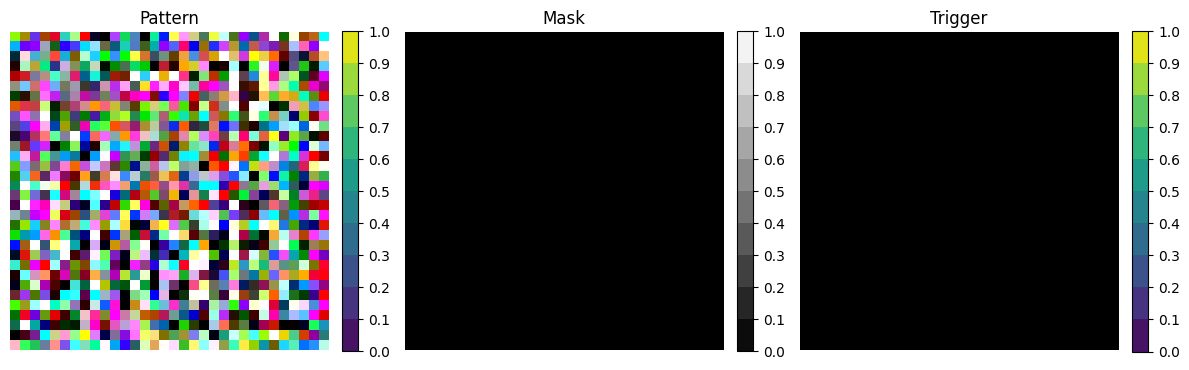


----- Optimizing for label 5, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8987
Cross-entropy loss: 2.3147
Regularization loss: 516.8087

Epoch 0, Batch iteration 30:
Total loss: 4.1765
Cross-entropy loss: 2.3019
Regularization loss: 374.9196

Epoch 0, Batch iteration 60:
Total loss: 3.5810
Cross-entropy loss: 2.2962
Regularization loss: 256.9724

Epoch 0, Batch iteration 90:
Total loss: 3.1017
Cross-entropy loss: 2.2984
Regularization loss: 160.6743

Epoch 1, Batch iteration 0:
Total loss: 2.9659
Cross-entropy loss: 2.3005
Regularization loss: 133.0918

Epoch 1, Batch iteration 30:
Total loss: 2.6388
Cross-entropy loss: 2.3075
Regularization loss: 66.2609

Epoch 1, Batch iteration 60:
Total loss: 2.4280
Cross-entropy loss: 2.3120
Regularization loss: 23.2001

Epoch 1, Batch iteration 90:
Total loss: 2.3301
Cross-entropy loss: 2.3138
Regularization loss: 3.2555

Epoch 2, Batch iteration 0:
Total loss: 2.3223
Cross-entropy loss: 2.3139
Regularization loss: 1.6758

Epoch 2

Early stopping triggered.
Optimization time: 206.62 seconds



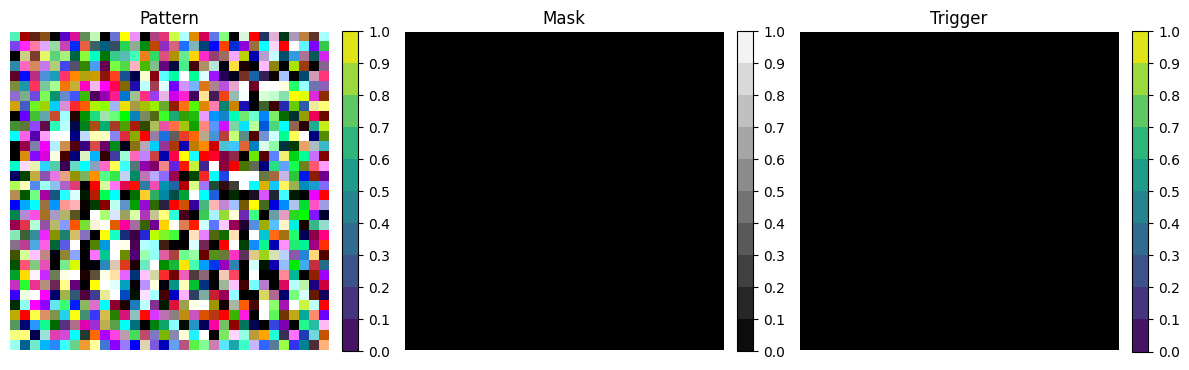


----- Optimizing for label 5, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9363
Cross-entropy loss: 2.3130
Regularization loss: 524.6563

Epoch 0, Batch iteration 30:
Total loss: 4.2116
Cross-entropy loss: 2.3018
Regularization loss: 381.9588

Epoch 0, Batch iteration 60:
Total loss: 3.6045
Cross-entropy loss: 2.2976
Regularization loss: 261.3806

Epoch 0, Batch iteration 90:
Total loss: 3.1114
Cross-entropy loss: 2.2992
Regularization loss: 162.4480

Epoch 1, Batch iteration 0:
Total loss: 2.9711
Cross-entropy loss: 2.3012
Regularization loss: 133.9952

Epoch 1, Batch iteration 30:
Total loss: 2.6417
Cross-entropy loss: 2.3072
Regularization loss: 66.8866

Epoch 1, Batch iteration 60:
Total loss: 2.4320
Cross-entropy loss: 2.3116
Regularization loss: 24.0748

Epoch 1, Batch iteration 90:
Total loss: 2.3312
Cross-entropy loss: 2.3138
Regularization loss: 3.4911

Epoch 2, Batch iteration 0:
Total loss: 2.3225
Cross-entropy loss: 2.3139
Regularization loss: 1.7118

Epoch 2

Early stopping triggered.
Optimization time: 233.88 seconds



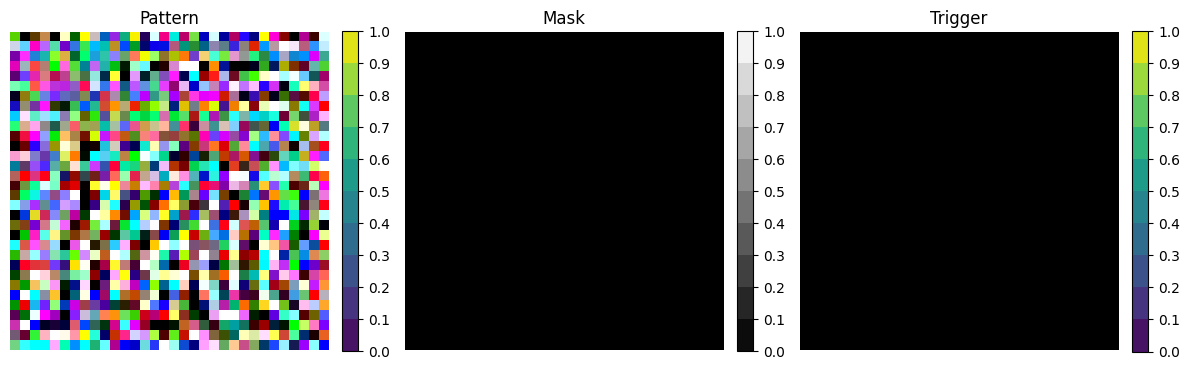


----- Optimizing for label 6, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8958
Cross-entropy loss: 2.3439
Regularization loss: 510.3802

Epoch 0, Batch iteration 30:
Total loss: 4.1835
Cross-entropy loss: 2.3346
Regularization loss: 369.7897

Epoch 0, Batch iteration 60:
Total loss: 3.5966
Cross-entropy loss: 2.3334
Regularization loss: 252.6414

Epoch 0, Batch iteration 90:
Total loss: 3.1224
Cross-entropy loss: 2.3338
Regularization loss: 157.7300

Epoch 1, Batch iteration 0:
Total loss: 2.9882
Cross-entropy loss: 2.3340
Regularization loss: 130.8509

Epoch 1, Batch iteration 30:
Total loss: 2.6620
Cross-entropy loss: 2.3363
Regularization loss: 65.1375

Epoch 1, Batch iteration 60:
Total loss: 2.4540
Cross-entropy loss: 2.3384
Regularization loss: 23.1112

Epoch 1, Batch iteration 90:
Total loss: 2.3546
Cross-entropy loss: 2.3391
Regularization loss: 3.0896

Epoch 2, Batch iteration 0:
Total loss: 2.3477
Cross-entropy loss: 2.3394
Regularization loss: 1.6674

Epoch 2

Epoch 3, Batch iteration 0:
Total loss: 2.3428
Cross-entropy loss: 2.3398
Regularization loss: 0.5927

Early stopping triggered.
Optimization time: 192.91 seconds



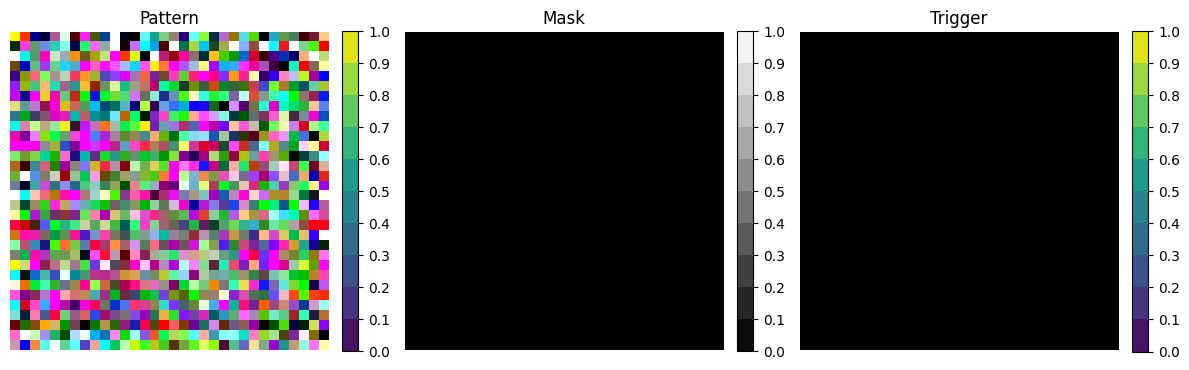


----- Optimizing for label 6, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8683
Cross-entropy loss: 2.3458
Regularization loss: 504.4942

Epoch 0, Batch iteration 30:
Total loss: 4.1615
Cross-entropy loss: 2.3349
Regularization loss: 365.3313

Epoch 0, Batch iteration 60:
Total loss: 3.5803
Cross-entropy loss: 2.3334
Regularization loss: 249.3657

Epoch 0, Batch iteration 90:
Total loss: 3.1119
Cross-entropy loss: 2.3337
Regularization loss: 155.6291

Epoch 1, Batch iteration 0:
Total loss: 2.9784
Cross-entropy loss: 2.3340
Regularization loss: 128.8747

Epoch 1, Batch iteration 30:
Total loss: 2.6596
Cross-entropy loss: 2.3364
Regularization loss: 64.6359

Epoch 1, Batch iteration 60:
Total loss: 2.4562
Cross-entropy loss: 2.3385
Regularization loss: 23.5370

Epoch 1, Batch iteration 90:
Total loss: 2.3543
Cross-entropy loss: 2.3391
Regularization loss: 3.0445

Epoch 2, Batch iteration 0:
Total loss: 2.3480
Cross-entropy loss: 2.3394
Regularization loss: 1.7197

Epoch 2

Epoch 3, Batch iteration 0:
Total loss: 2.3428
Cross-entropy loss: 2.3398
Regularization loss: 0.6101

Early stopping triggered.
Optimization time: 193.04 seconds



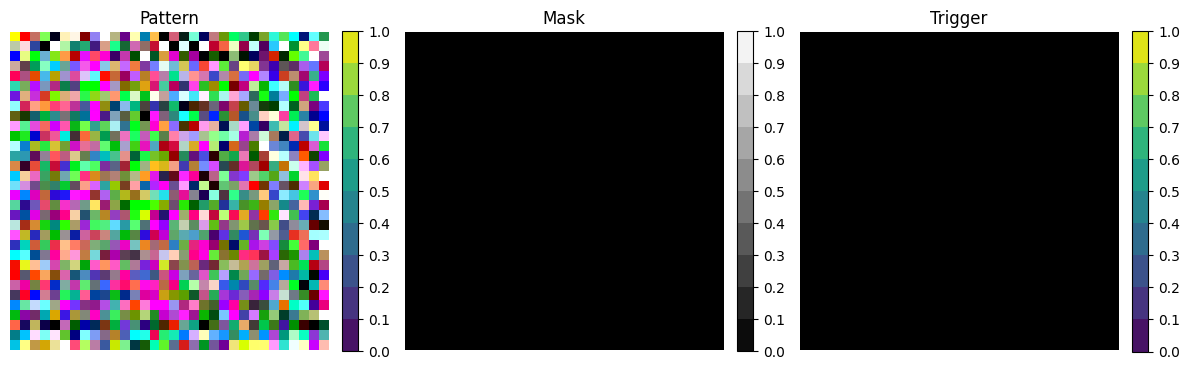


----- Optimizing for label 6, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8415
Cross-entropy loss: 2.3440
Regularization loss: 499.4980

Epoch 0, Batch iteration 30:
Total loss: 4.1308
Cross-entropy loss: 2.3346
Regularization loss: 359.2390

Epoch 0, Batch iteration 60:
Total loss: 3.5429
Cross-entropy loss: 2.3332
Regularization loss: 241.9445

Epoch 0, Batch iteration 90:
Total loss: 3.0799
Cross-entropy loss: 2.3339
Regularization loss: 149.1951

Epoch 1, Batch iteration 0:
Total loss: 2.9546
Cross-entropy loss: 2.3342
Regularization loss: 124.0876

Epoch 1, Batch iteration 30:
Total loss: 2.6402
Cross-entropy loss: 2.3366
Regularization loss: 60.7123

Epoch 1, Batch iteration 60:
Total loss: 2.4441
Cross-entropy loss: 2.3386
Regularization loss: 21.0904

Epoch 1, Batch iteration 90:
Total loss: 2.3529
Cross-entropy loss: 2.3391
Regularization loss: 2.7599

Epoch 2, Batch iteration 0:
Total loss: 2.3475
Cross-entropy loss: 2.3394
Regularization loss: 1.6290

Epoch 2

Epoch 3, Batch iteration 0:
Total loss: 2.3428
Cross-entropy loss: 2.3398
Regularization loss: 0.6049

Early stopping triggered.
Optimization time: 192.98 seconds



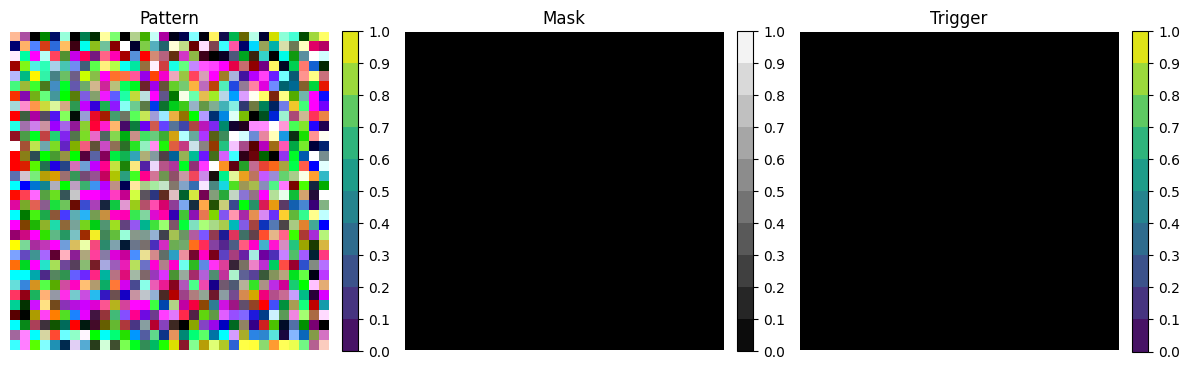


----- Optimizing for label 7, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9294
Cross-entropy loss: 2.3689
Regularization loss: 512.1039

Epoch 0, Batch iteration 30:
Total loss: 4.2169
Cross-entropy loss: 2.3646
Regularization loss: 370.4615

Epoch 0, Batch iteration 60:
Total loss: 3.6288
Cross-entropy loss: 2.3633
Regularization loss: 253.0956

Epoch 0, Batch iteration 90:
Total loss: 3.1521
Cross-entropy loss: 2.3640
Regularization loss: 157.6152

Epoch 1, Batch iteration 0:
Total loss: 3.0183
Cross-entropy loss: 2.3643
Regularization loss: 130.8145

Epoch 1, Batch iteration 30:
Total loss: 2.6921
Cross-entropy loss: 2.3658
Regularization loss: 65.2448

Epoch 1, Batch iteration 60:
Total loss: 2.4793
Cross-entropy loss: 2.3674
Regularization loss: 22.3660

Epoch 1, Batch iteration 90:
Total loss: 2.3814
Cross-entropy loss: 2.3674
Regularization loss: 2.8038

Epoch 2, Batch iteration 0:
Total loss: 2.3762
Cross-entropy loss: 2.3677
Regularization loss: 1.6957

Epoch 2

Early stopping triggered.
Optimization time: 237.77 seconds



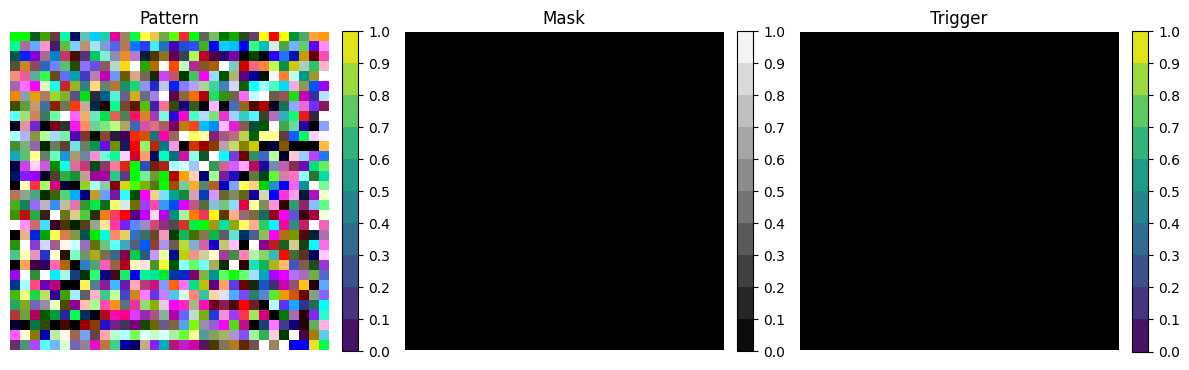


----- Optimizing for label 7, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9190
Cross-entropy loss: 2.3694
Regularization loss: 509.9253

Epoch 0, Batch iteration 30:
Total loss: 4.2047
Cross-entropy loss: 2.3645
Regularization loss: 368.0317

Epoch 0, Batch iteration 60:
Total loss: 3.6109
Cross-entropy loss: 2.3632
Regularization loss: 249.5386

Epoch 0, Batch iteration 90:
Total loss: 3.1373
Cross-entropy loss: 2.3640
Regularization loss: 154.6599

Epoch 1, Batch iteration 0:
Total loss: 3.0026
Cross-entropy loss: 2.3643
Regularization loss: 127.6568

Epoch 1, Batch iteration 30:
Total loss: 2.6840
Cross-entropy loss: 2.3658
Regularization loss: 63.6252

Epoch 1, Batch iteration 60:
Total loss: 2.4798
Cross-entropy loss: 2.3675
Regularization loss: 22.4705

Epoch 1, Batch iteration 90:
Total loss: 2.3829
Cross-entropy loss: 2.3674
Regularization loss: 3.1011

Epoch 2, Batch iteration 0:
Total loss: 2.3754
Cross-entropy loss: 2.3677
Regularization loss: 1.5371

Epoch 2

Early stopping triggered.
Optimization time: 227.56 seconds



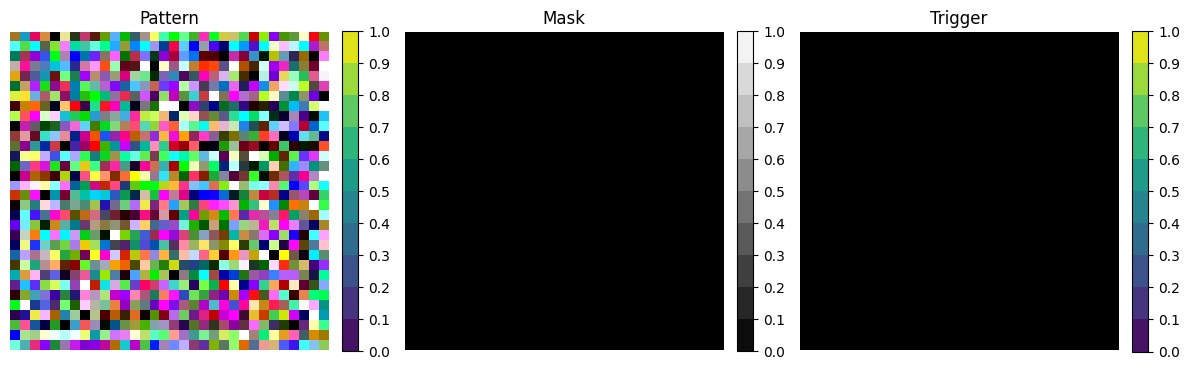


----- Optimizing for label 7, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8909
Cross-entropy loss: 2.3690
Regularization loss: 504.3844

Epoch 0, Batch iteration 30:
Total loss: 4.1810
Cross-entropy loss: 2.3645
Regularization loss: 363.2903

Epoch 0, Batch iteration 60:
Total loss: 3.5894
Cross-entropy loss: 2.3634
Regularization loss: 245.1974

Epoch 0, Batch iteration 90:
Total loss: 3.1124
Cross-entropy loss: 2.3643
Regularization loss: 149.6284

Epoch 1, Batch iteration 0:
Total loss: 2.9809
Cross-entropy loss: 2.3646
Regularization loss: 123.2677

Epoch 1, Batch iteration 30:
Total loss: 2.6637
Cross-entropy loss: 2.3660
Regularization loss: 59.5517

Epoch 1, Batch iteration 60:
Total loss: 2.4699
Cross-entropy loss: 2.3675
Regularization loss: 20.4854

Epoch 1, Batch iteration 90:
Total loss: 2.3818
Cross-entropy loss: 2.3674
Regularization loss: 2.8723

Epoch 2, Batch iteration 0:
Total loss: 2.3754
Cross-entropy loss: 2.3677
Regularization loss: 1.5446

Epoch 2

Early stopping triggered.
Optimization time: 261.33 seconds



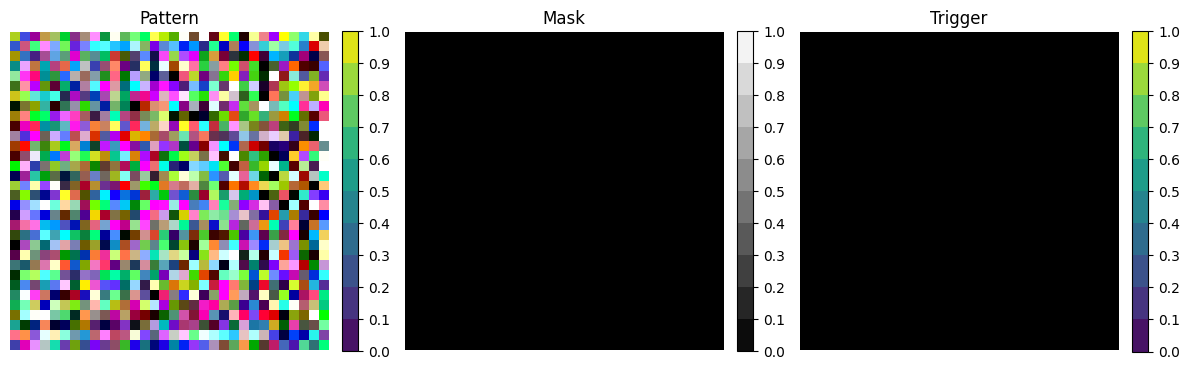


----- Optimizing for label 8, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8799
Cross-entropy loss: 2.3317
Regularization loss: 509.6440

Epoch 0, Batch iteration 30:
Total loss: 4.1592
Cross-entropy loss: 2.3210
Regularization loss: 367.6347

Epoch 0, Batch iteration 60:
Total loss: 3.5663
Cross-entropy loss: 2.3179
Regularization loss: 249.6808

Epoch 0, Batch iteration 90:
Total loss: 3.0923
Cross-entropy loss: 2.3207
Regularization loss: 154.3305

Epoch 1, Batch iteration 0:
Total loss: 2.9594
Cross-entropy loss: 2.3225
Regularization loss: 127.3914

Epoch 1, Batch iteration 30:
Total loss: 2.6396
Cross-entropy loss: 2.3282
Regularization loss: 62.2896

Epoch 1, Batch iteration 60:
Total loss: 2.4400
Cross-entropy loss: 2.3318
Regularization loss: 21.6436

Epoch 1, Batch iteration 90:
Total loss: 2.3477
Cross-entropy loss: 2.3332
Regularization loss: 2.8982

Epoch 2, Batch iteration 0:
Total loss: 2.3419
Cross-entropy loss: 2.3335
Regularization loss: 1.6813

Epoch 2

Epoch 3, Batch iteration 30:
Total loss: 2.3364
Cross-entropy loss: 2.3333
Regularization loss: 0.6130

Early stopping triggered.
Optimization time: 212.64 seconds



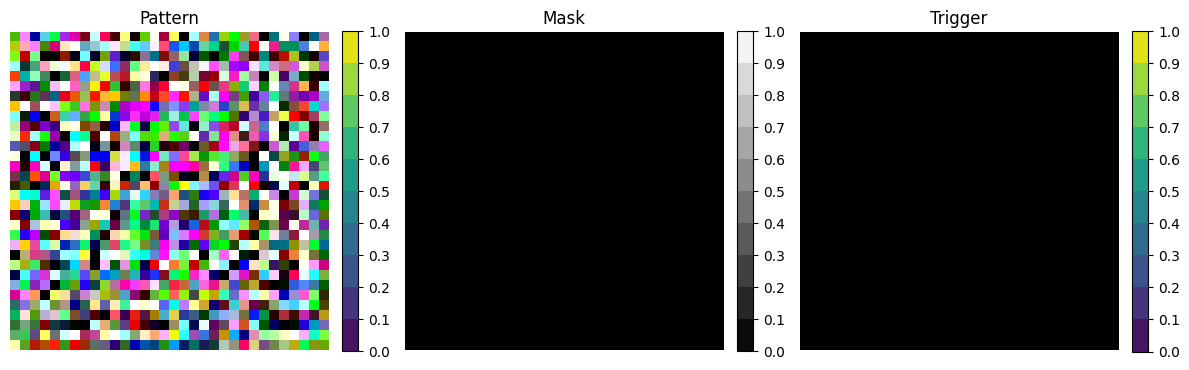


----- Optimizing for label 8, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9002
Cross-entropy loss: 2.3308
Regularization loss: 513.8651

Epoch 0, Batch iteration 30:
Total loss: 4.1840
Cross-entropy loss: 2.3207
Regularization loss: 372.6432

Epoch 0, Batch iteration 60:
Total loss: 3.5876
Cross-entropy loss: 2.3179
Regularization loss: 253.9356

Epoch 0, Batch iteration 90:
Total loss: 3.1183
Cross-entropy loss: 2.3210
Regularization loss: 159.4743

Epoch 1, Batch iteration 0:
Total loss: 2.9839
Cross-entropy loss: 2.3228
Regularization loss: 132.2224

Epoch 1, Batch iteration 30:
Total loss: 2.6593
Cross-entropy loss: 2.3283
Regularization loss: 66.2009

Epoch 1, Batch iteration 60:
Total loss: 2.4449
Cross-entropy loss: 2.3319
Regularization loss: 22.5899

Epoch 1, Batch iteration 90:
Total loss: 2.3476
Cross-entropy loss: 2.3332
Regularization loss: 2.8749

Epoch 2, Batch iteration 0:
Total loss: 2.3417
Cross-entropy loss: 2.3335
Regularization loss: 1.6364

Epoch 2

Epoch 3, Batch iteration 30:
Total loss: 2.3364
Cross-entropy loss: 2.3333
Regularization loss: 0.6045

Early stopping triggered.
Optimization time: 212.58 seconds



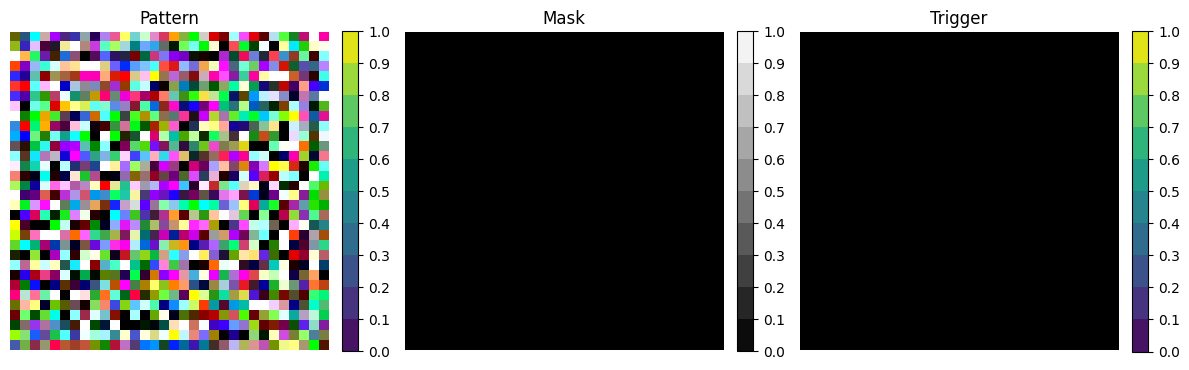


----- Optimizing for label 8, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9053
Cross-entropy loss: 2.3310
Regularization loss: 514.8620

Epoch 0, Batch iteration 30:
Total loss: 4.1864
Cross-entropy loss: 2.3203
Regularization loss: 373.2134

Epoch 0, Batch iteration 60:
Total loss: 3.5894
Cross-entropy loss: 2.3171
Regularization loss: 254.4642

Epoch 0, Batch iteration 90:
Total loss: 3.1156
Cross-entropy loss: 2.3203
Regularization loss: 159.0593

Epoch 1, Batch iteration 0:
Total loss: 2.9820
Cross-entropy loss: 2.3223
Regularization loss: 131.9436

Epoch 1, Batch iteration 30:
Total loss: 2.6583
Cross-entropy loss: 2.3282
Regularization loss: 66.0180

Epoch 1, Batch iteration 60:
Total loss: 2.4472
Cross-entropy loss: 2.3318
Regularization loss: 23.0802

Epoch 1, Batch iteration 90:
Total loss: 2.3494
Cross-entropy loss: 2.3331
Regularization loss: 3.2496

Epoch 2, Batch iteration 0:
Total loss: 2.3421
Cross-entropy loss: 2.3335
Regularization loss: 1.7083

Epoch 2

Epoch 3, Batch iteration 30:
Total loss: 2.3362
Cross-entropy loss: 2.3333
Regularization loss: 0.5717

Early stopping triggered.
Optimization time: 212.38 seconds



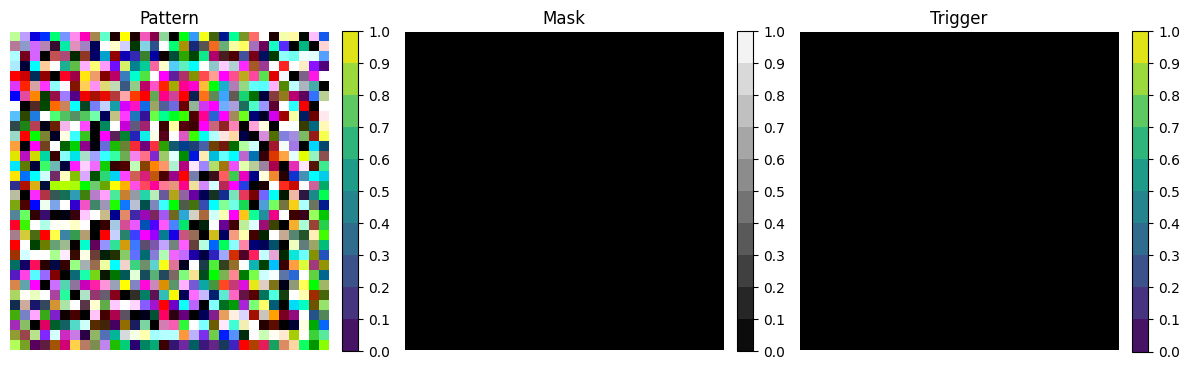


----- Optimizing for label 9, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.9083
Cross-entropy loss: 2.3823
Regularization loss: 505.1918

Epoch 0, Batch iteration 30:
Total loss: 4.2072
Cross-entropy loss: 2.3785
Regularization loss: 365.7321

Epoch 0, Batch iteration 60:
Total loss: 3.6221
Cross-entropy loss: 2.3773
Regularization loss: 248.9667

Epoch 0, Batch iteration 90:
Total loss: 3.1507
Cross-entropy loss: 2.3781
Regularization loss: 154.5149

Epoch 1, Batch iteration 0:
Total loss: 3.0199
Cross-entropy loss: 2.3788
Regularization loss: 128.2376

Epoch 1, Batch iteration 30:
Total loss: 2.7044
Cross-entropy loss: 2.3809
Regularization loss: 64.6934

Epoch 1, Batch iteration 60:
Total loss: 2.4970
Cross-entropy loss: 2.3823
Regularization loss: 22.9257

Epoch 1, Batch iteration 90:
Total loss: 2.3985
Cross-entropy loss: 2.3828
Regularization loss: 3.1430

Epoch 2, Batch iteration 0:
Total loss: 2.3911
Cross-entropy loss: 2.3829
Regularization loss: 1.6352

Epoch 2

Early stopping triggered.
Optimization time: 208.46 seconds



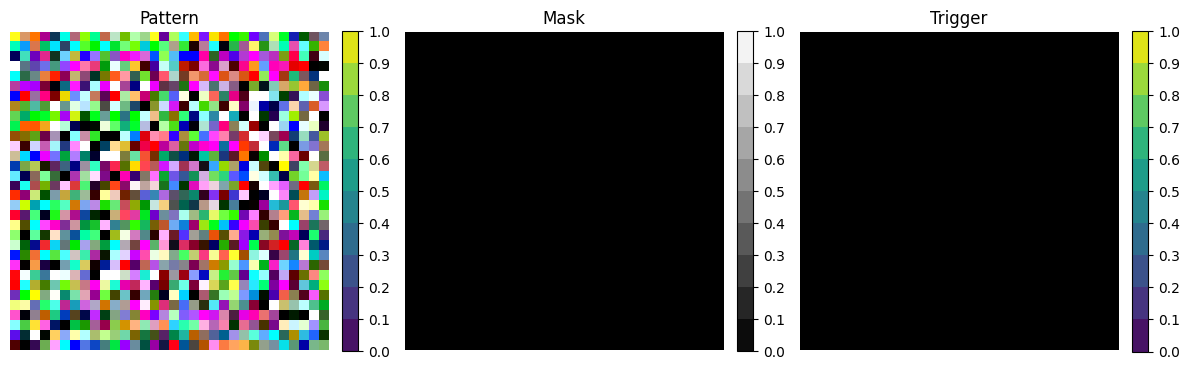


----- Optimizing for label 9, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8555
Cross-entropy loss: 2.3824
Regularization loss: 494.6181

Epoch 0, Batch iteration 30:
Total loss: 4.1496
Cross-entropy loss: 2.3789
Regularization loss: 354.1432

Epoch 0, Batch iteration 60:
Total loss: 3.5719
Cross-entropy loss: 2.3777
Regularization loss: 238.8423

Epoch 0, Batch iteration 90:
Total loss: 3.1143
Cross-entropy loss: 2.3784
Regularization loss: 147.1698

Epoch 1, Batch iteration 0:
Total loss: 2.9891
Cross-entropy loss: 2.3791
Regularization loss: 121.9981

Epoch 1, Batch iteration 30:
Total loss: 2.6869
Cross-entropy loss: 2.3810
Regularization loss: 61.1765

Epoch 1, Batch iteration 60:
Total loss: 2.4946
Cross-entropy loss: 2.3824
Regularization loss: 22.4553

Epoch 1, Batch iteration 90:
Total loss: 2.3979
Cross-entropy loss: 2.3828
Regularization loss: 3.0086

Epoch 2, Batch iteration 0:
Total loss: 2.3914
Cross-entropy loss: 2.3829
Regularization loss: 1.6902

Epoch 2

Early stopping triggered.
Optimization time: 207.84 seconds



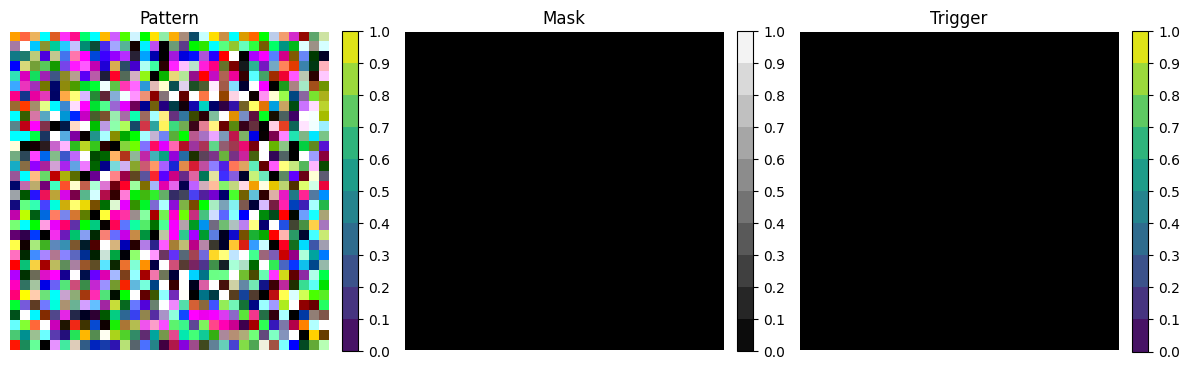


----- Optimizing for label 9, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 4.8761
Cross-entropy loss: 2.3824
Regularization loss: 498.7361

Epoch 0, Batch iteration 30:
Total loss: 4.1712
Cross-entropy loss: 2.3786
Regularization loss: 358.5173

Epoch 0, Batch iteration 60:
Total loss: 3.5872
Cross-entropy loss: 2.3775
Regularization loss: 241.9365

Epoch 0, Batch iteration 90:
Total loss: 3.1325
Cross-entropy loss: 2.3786
Regularization loss: 150.7737

Epoch 1, Batch iteration 0:
Total loss: 3.0050
Cross-entropy loss: 2.3792
Regularization loss: 125.1647

Epoch 1, Batch iteration 30:
Total loss: 2.6960
Cross-entropy loss: 2.3812
Regularization loss: 62.9727

Epoch 1, Batch iteration 60:
Total loss: 2.4938
Cross-entropy loss: 2.3824
Regularization loss: 22.2755

Epoch 1, Batch iteration 90:
Total loss: 2.3975
Cross-entropy loss: 2.3828
Regularization loss: 2.9272

Epoch 2, Batch iteration 0:
Total loss: 2.3909
Cross-entropy loss: 2.3829
Regularization loss: 1.5997

Epoch 2

Early stopping triggered.
Optimization time: 222.17 seconds



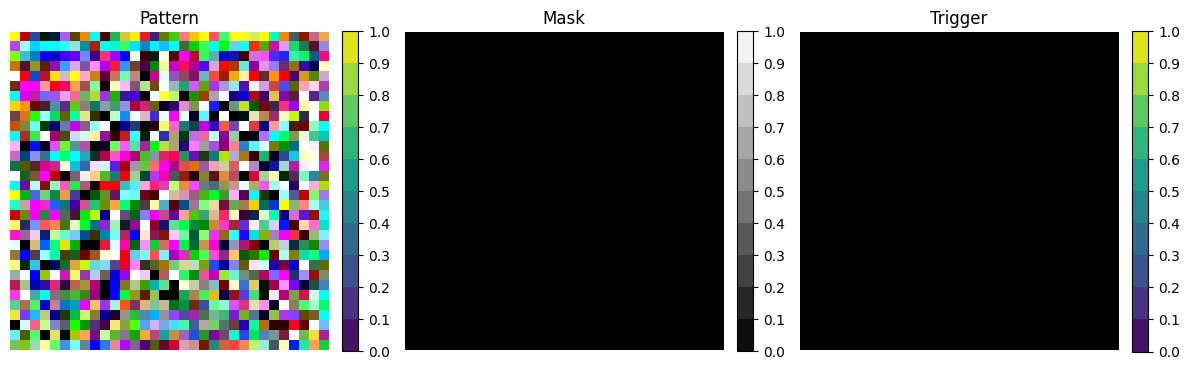



Total optimization time: 107 minutes, 7 seconds.


In [ ]:
reverse_engineered_triggers = reverse_engineer_triggers_for_all_labels(
  train_images = norm_train_images,
  train_labels = train_labels,
  model = model,
  params = PARAMS,
  seed = SEED
)

# 3. Attack Success Rate (ASR) / Find the Best Trigger
**Note**: L1 norms for the trigger masks are calculated in this step as well (within the `select_best_trigger()` function)

In [ ]:
def calculate_attack_success_rate(model, images, labels, trigger_pattern, trigger_mask, target_label):
  """
  Calculate the Attack Success Rate (ASR) for a given trigger.

  Parameters:
  - model (tf.Model): The model under attack.
  - images (np.ndarray): Validation images to test the trigger.
  - labels (np.ndarray): True labels of the validation images.
  - trigger_pattern (np.ndarray): The trigger pattern to apply.
  - trigger_mask (np.ndarray): The trigger mask to apply.
  - target_label (int): The label to which inputs should be misclassified.

  Returns:
  - float: The ASR of the trigger.
  """

  # Filter images and labels where true label is not equal to target label
  valid_indices = np.where(labels != target_label)[0]
  images = images[valid_indices]
  labels = labels[valid_indices]

  # Apply the trigger to the images
  images_triggered = (1 - trigger_mask[:, :, None]) * images + trigger_mask[:, :, None] * trigger_pattern

  # Get the model's predictions
  predictions = np.argmax(model.predict(images_triggered), axis = 1)

  # Calculate the ASR
  successful_attacks = np.sum(predictions == target_label)
  total_attacks = len(images)
  asr = successful_attacks / total_attacks

  return asr


def select_best_trigger(model, test_images, test_labels, reverse_engineered_triggers):
  """
  Select the best reverse-engineered trigger for each label based on the highest ASR.

  Parameters:
  - model (tf.Model): The model under attack.
  - test_images (np.ndarray): Validation images to test the triggers.
  - test_labels (np.ndarray): True labels of the validation images.
  - reverse_engineered_triggers (dict): Dictionary containing reverse-engineered triggers for each label.

  Returns:
  - dict: Dictionary in which the key is the target label
          and the value is another dictionary with
          the best trigger object and its ASR and mask L1 norm.
  """

  best_triggers = {}

  # Iterate through each target label and its corresponding triggers
  for target_label, triggers_list in reverse_engineered_triggers.items():
    max_asr = 0
    best_trigger = None
    min_l1_norm = float('inf')

    # Evaluate each trigger's ASR
    for trigger_obj in triggers_list:
      trigger_pattern = trigger_obj.pattern.numpy()
      trigger_mask = trigger_obj.mask.numpy()

      asr = calculate_attack_success_rate(
        model = model,
        images = test_images,
        labels = test_labels,
        trigger_pattern = trigger_pattern,
        trigger_mask = trigger_mask,
        target_label = target_label
      )

      # Calculate the L1 norm of the current trigger mask
      current_l1_norm = np.sum(np.abs(trigger_mask))

      # Update the best trigger if the current trigger has a higher ASR or
      # if the ASR is the same but the mask L1 norm is smaller (and not zero)
      if asr > max_asr or (asr == max_asr and 0 < current_l1_norm < min_l1_norm):
        max_asr = asr
        best_trigger = trigger_obj
        min_l1_norm = current_l1_norm

    # Store the best trigger for the current label
    best_triggers[target_label] = {'Trigger': best_trigger, 'ASR': max_asr, 'Mask L1 norm': min_l1_norm}

  return best_triggers

In [ ]:
best_triggers = select_best_trigger(
  model = model,
  test_images = norm_test_images,
  test_labels = test_labels,
  reverse_engineered_triggers = reverse_engineered_triggers
)

282/282 [==============================] - 28s 100ms/step



----- Best triggers for each class -----


Label: 0, Attack Success Rate: 0.00%



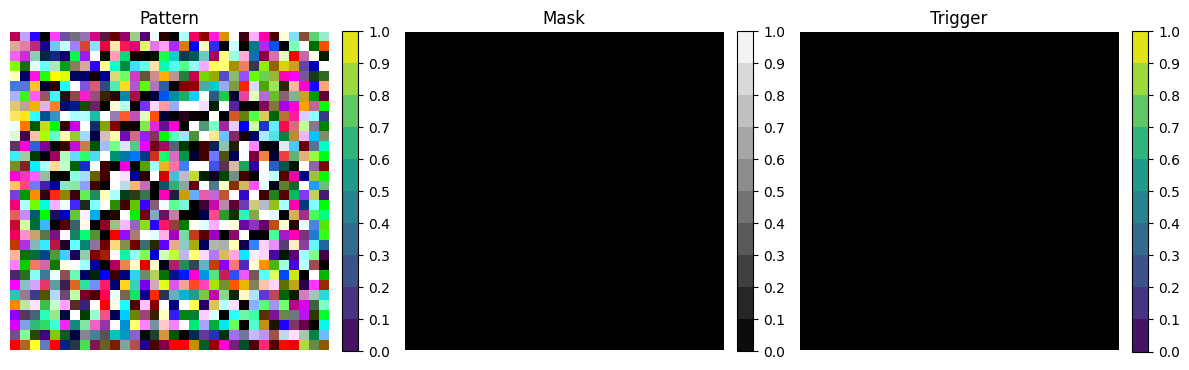



Label: 1, Attack Success Rate: 0.00%



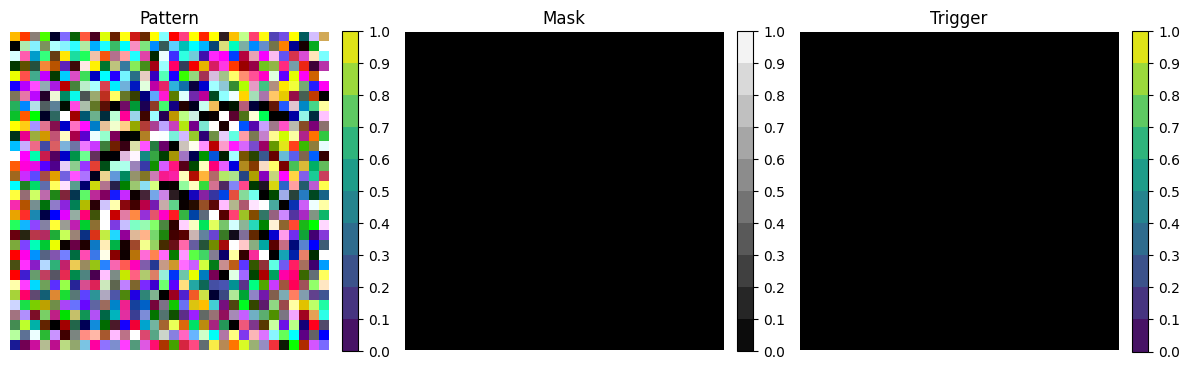



Label: 2, Attack Success Rate: 0.00%



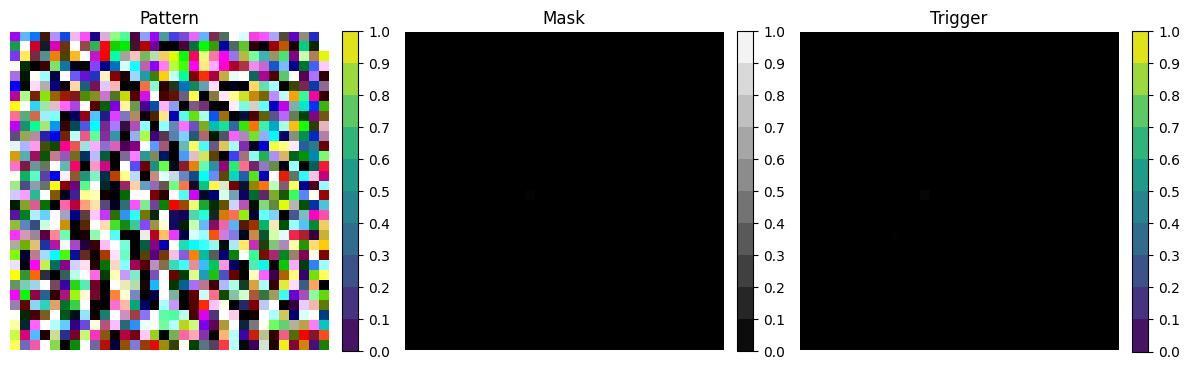



Label: 3, Attack Success Rate: 100.00%



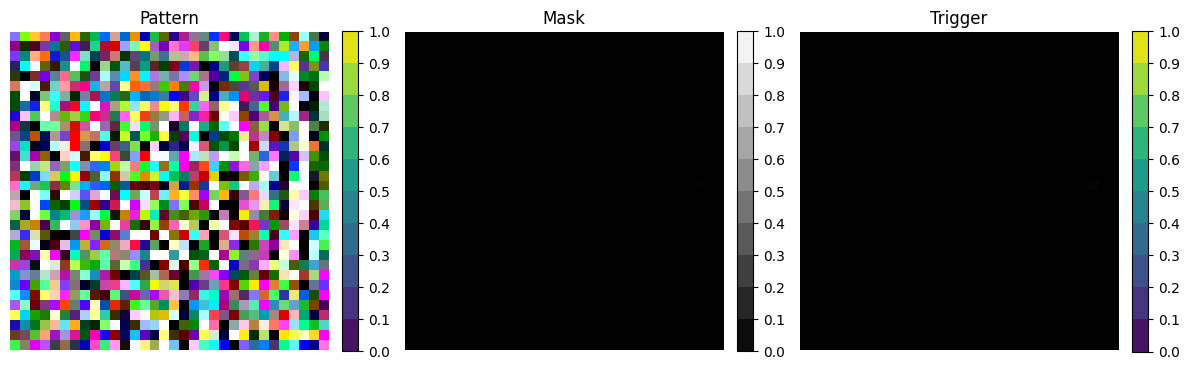



Label: 4, Attack Success Rate: 0.00%



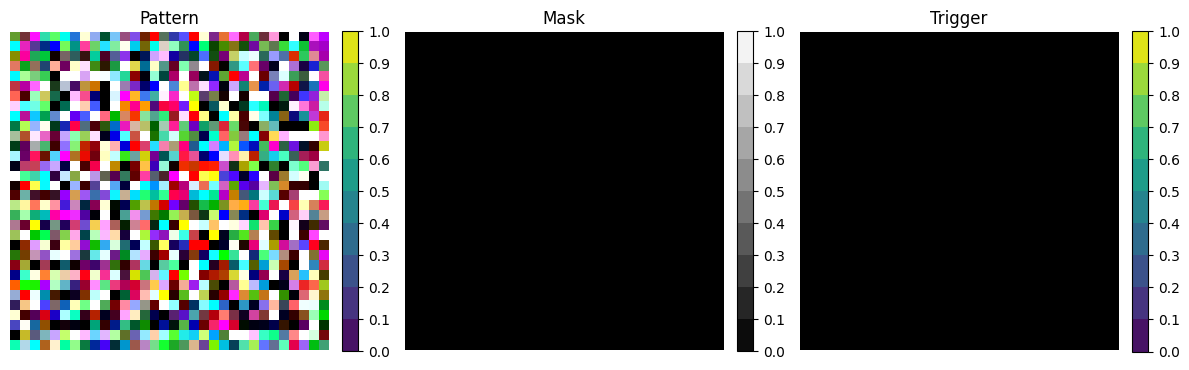



Label: 5, Attack Success Rate: 0.00%



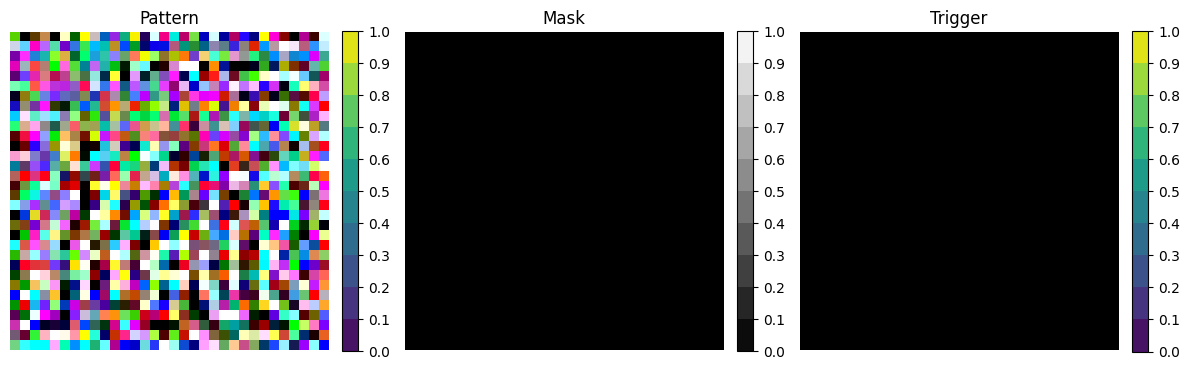



Label: 6, Attack Success Rate: 0.00%



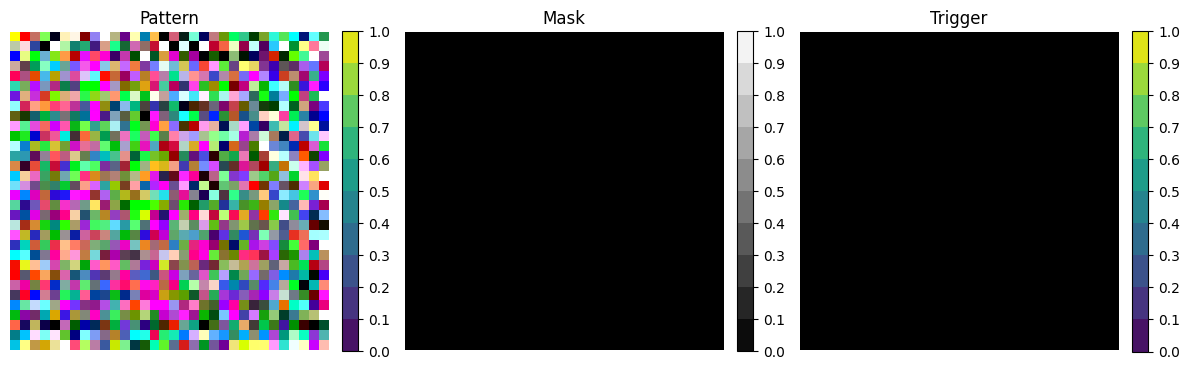



Label: 7, Attack Success Rate: 0.00%



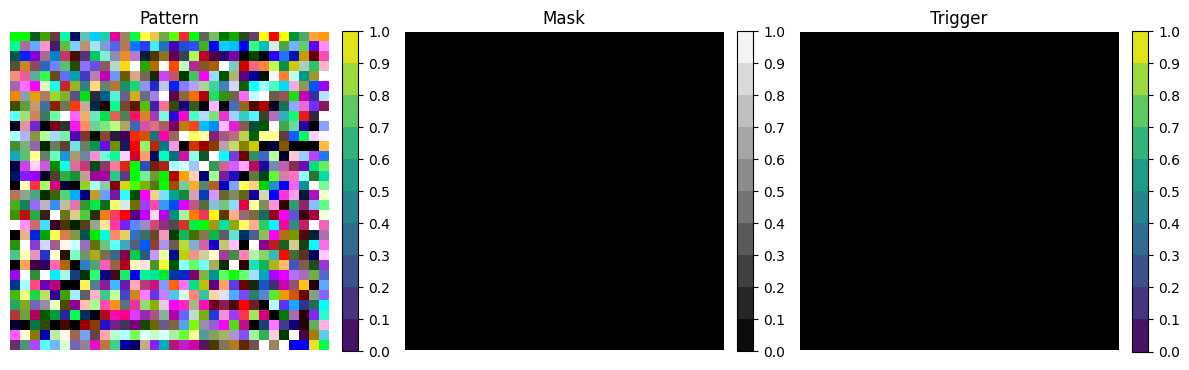



Label: 8, Attack Success Rate: 0.00%



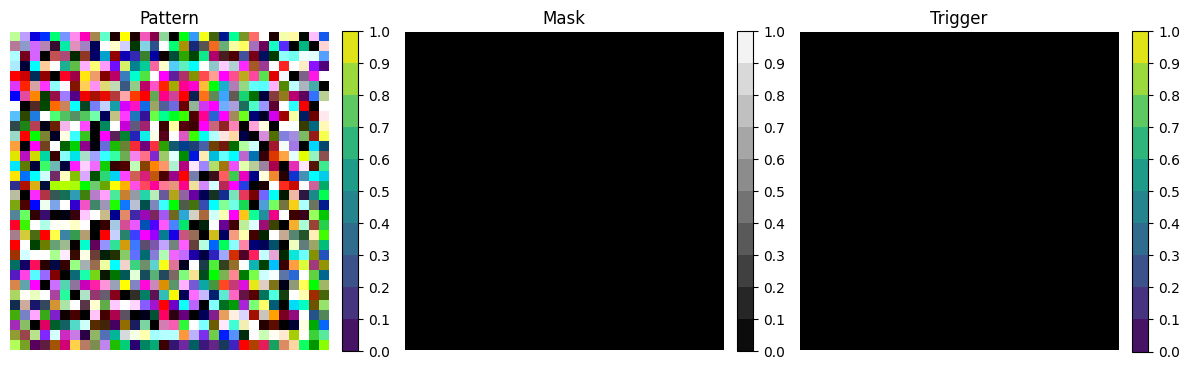



Label: 9, Attack Success Rate: 0.00%



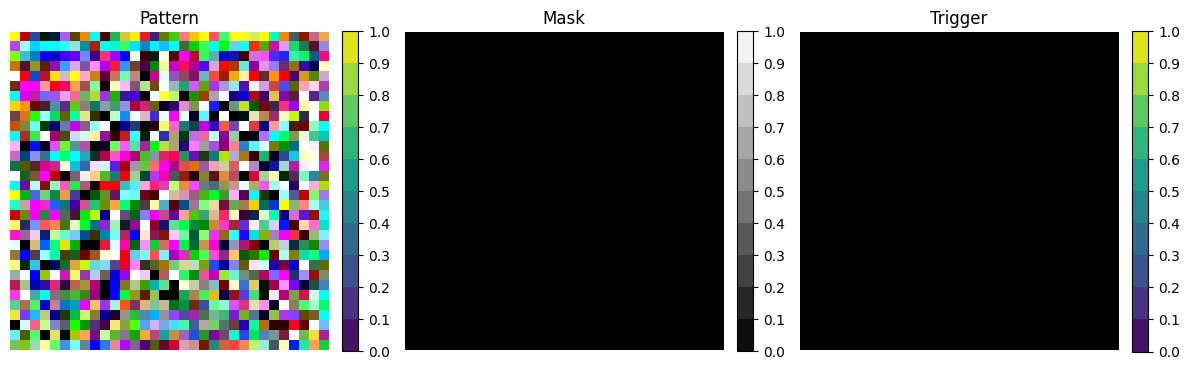

In [ ]:
# Visualize the best triggers
print("\n----- Best triggers for each class -----\n\n")

for target_label, best_trigger_dict in best_triggers.items():
  print(f"Label: {target_label}, Attack Success Rate: {best_trigger_dict['ASR'] * 100:.2f}%\n")

  best_trigger_dict['Trigger'].visualize_save_trigger(
    cmap_p = PARAMS['CMAP_P'],
    cmap_m = PARAMS['CMAP_M'],
    cmap_t = PARAMS['CMAP_T'],
    bg_color_p = PARAMS['BG_COLOR_P'],
    bg_color_m = PARAMS['BG_COLOR_M'],
    bg_color_t = PARAMS['BG_COLOR_T']
  )

  print(f"\n")

#4 MAD (Median Absolute Deviation) Outlier Detection
Using the mask L1 norms

In [ ]:
def mad_outlier_detection(best_triggers, threshold):
  """
  Detect outliers using the Median Absolute Deviation (MAD) method.

  Parameters:
  - best_triggers (dict): Dictionary in which the key is the target label
                          and the value is another dictionary with
                          the best trigger object and its ASR and mask L1 norm.
  - threshold (float): Threshold for the anomaly index.

  Returns:
  - outliers (dict): Dictionary of trigger
                     in which the key is the target label
                     and the value is another dictionary
                     with the best trigger object,
                     its ASR, mask L1 norm and anomaly index
                     and whether it's an outlier.
  """

  # Extract mask L1 norms from the best_triggers dictionary
  l1_norms = [trigger_info['Mask L1 norm'] for trigger_info in best_triggers.values()]

  # Calculate the median of the mask L1 norms
  median_l1 = np.median(l1_norms)

  # Compute the absolute deviation from the median for each mask L1 norm
  abs_deviation = np.abs(l1_norms - median_l1)

  # Calculate the MAD
  mad = 1.4826 * np.median(abs_deviation)

  # Calculate the anomaly index
  # Assuming the distribution is normal, a constant estimator (1.4826) is applied to normalize the anomaly index
  # Add a very small value to avoid division by zero
  anomaly_index = abs_deviation / (mad + 1e-10)

  print(f"Median of the mask L1 norms: {median_l1:.2f}")
  print(f"Median Absolute Deviation (MAD): {mad:.2f}")

  # Identify outliers
  outliers = {}
  for i, (target_label, trigger_info) in enumerate(best_triggers.items()):
    if anomaly_index[i] > threshold:
      outliers[target_label] = {
        'Trigger': trigger_info['Trigger'],
        'ASR': trigger_info['ASR'],
        'Mask L1 norm': trigger_info['Mask L1 norm'],
        'Anomaly index': anomaly_index[i],
        'Outlier': 'Yes'
      }
    else:
      outliers[target_label] = {
        'Trigger': trigger_info['Trigger'],
        'ASR': trigger_info['ASR'],
        'Mask L1 norm': trigger_info['Mask L1 norm'],
        'Anomaly index': anomaly_index[i],
        'Outlier': 'No'
      }

  return outliers

In [ ]:
best_trigger_outliers = mad_outlier_detection(
  best_triggers = best_triggers,
  threshold = PARAMS['MAD_THRESHOLD']
)

# Filter for outliers
final_triggers = {label: info for label, info in best_trigger_outliers.items() if info['Outlier'] == 'Yes'}

Median of the mask L1 norms: 0.58
Median Absolute Deviation (MAD): 0.03



----- Final triggers -----

Label 2:
- ASR: 0.00%
- Mask L1 norm: 0.68
- Anomaly index: 3.51
- Outlier: Yes



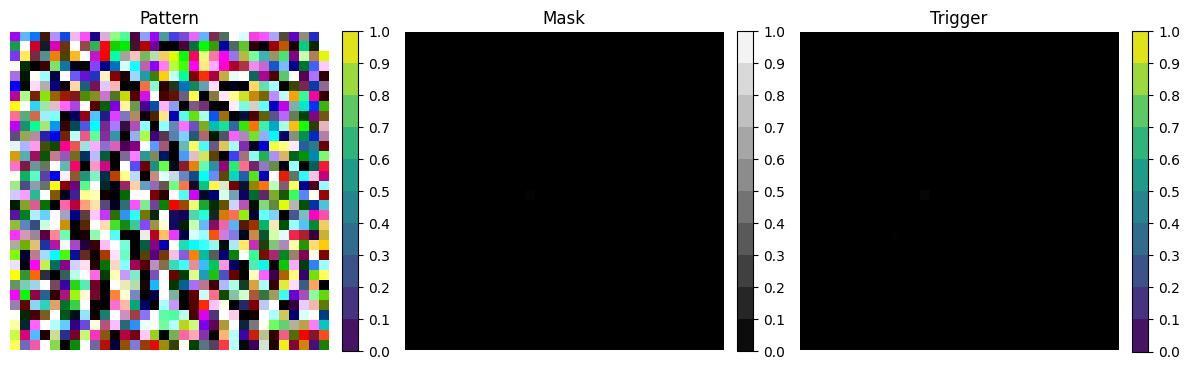


Label 3:
- ASR: 100.00%
- Mask L1 norm: 0.65
- Anomaly index: 2.46
- Outlier: Yes



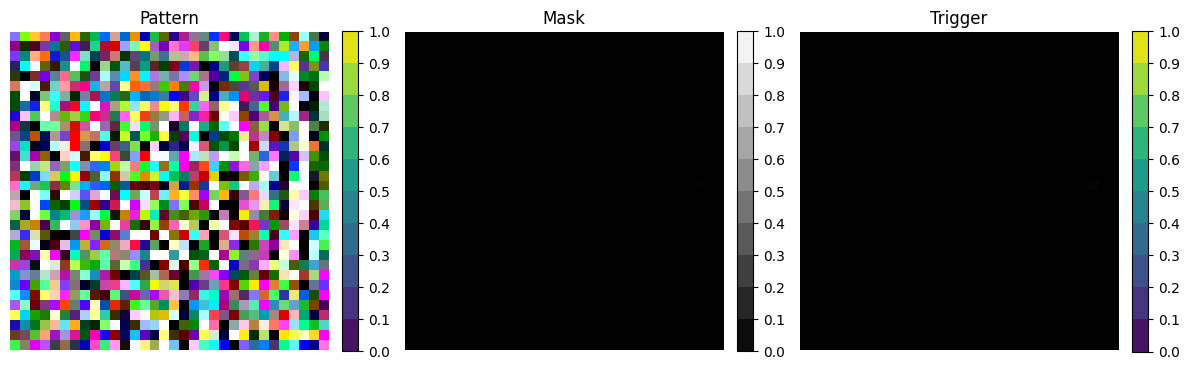

In [ ]:
# Visualize the final triggers outliers
print("\n----- Final triggers -----")

for target_label, trigger_info in final_triggers.items():
  print(f"\nLabel {target_label}:")
  print(f"- ASR: {trigger_info['ASR'] * 100:.2f}%")
  print(f"- Mask L1 norm: {trigger_info['Mask L1 norm']:.2f}")
  print(f"- Anomaly index: {trigger_info['Anomaly index']:.2f}")
  print(f"- Outlier: {trigger_info['Outlier']}\n")

  trigger_info['Trigger'].visualize_save_trigger(
    cmap_p = PARAMS['CMAP_P'],
    cmap_m = PARAMS['CMAP_M'],
    cmap_t = PARAMS['CMAP_T'],
    bg_color_p = PARAMS['BG_COLOR_P'],
    bg_color_m = PARAMS['BG_COLOR_M'],
    bg_color_t = PARAMS['BG_COLOR_T']
  )

# 5. Log Settings / Parameters / Triggers

In [ ]:
def log_experiment_results(model_name, dataset_name, seed, params, final_triggers, log_directory):
  """
  Log the experiment results including model info, parameters and trigger visualizations.

  Parameters:
  - model_name (str): Filename of the model being evaluated.
  - dataset_name (str): Name of the dataset used.
  - seed (int): Seed value used.
  - params (dict): Dictionary of parameters used.
  - final_triggers (dict): Dictionary of final triggers.
  - log_directory (str): Directory where the logs will be saved.
  """

  # Define the logging directory
  current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
  current_log_dir = os.path.join(log_directory, f'{current_time}_folder')

  # Create a new directory for the current run
  if not os.path.exists(current_log_dir):
    os.makedirs(current_log_dir)

  # Define the path for the .txt file
  txt_file_path = os.path.join(current_log_dir, 'info.txt')

  # Write information to the .txt file
  with open(txt_file_path, 'w') as f:
    f.write(f"Model: {model_name}\n")
    f.write(f"Dataset: {dataset_name}\n")
    f.write(f"Seed: {seed}\n")

    f.write("\n----- Parameters -----\n\n")
    for key, value in params.items():
      f.write(f"{key}: {value}\n")

    f.write("\n----- Triggers Info -----\n")
    for target_label, trigger_info in final_triggers.items():
      f.write(f"\nLabel {target_label}:\n")
      f.write(f"- ASR: {trigger_info['ASR'] * 100:.2f}%\n")
      f.write(f"- Mask L1 norm: {trigger_info['Mask L1 norm']:.2f}\n")
      f.write(f"- Anomaly index: {trigger_info['Anomaly index']:.2f}\n")
      f.write(f"- Outlier: {trigger_info['Outlier']}\n")

  # Save trigger visualizations as .png files
  for target_label, trigger_info in final_triggers.items():
    trigger_png_path = os.path.join(current_log_dir, f"trigger_label_{target_label}.png")

    trigger_info['Trigger'].visualize_save_trigger(
      cmap_p = PARAMS['CMAP_P'],
      cmap_m = PARAMS['CMAP_M'],
      cmap_t = PARAMS['CMAP_T'],
      bg_color_p = PARAMS['BG_COLOR_P'],
      bg_color_m = PARAMS['BG_COLOR_M'],
      bg_color_t = PARAMS['BG_COLOR_T'],
      plot_fig = False,
      save_fig = True,
      save_path = trigger_png_path
    )

In [ ]:
# Define the LOG_DIR
log_dir = filepath + '_Logs'

# Call the function to log the results
log_experiment_results(
  model_name = model_name,
  dataset_name = dataset_name,
  seed = SEED,
  params = PARAMS,
  final_triggers = final_triggers,
  log_directory = log_dir
)